# Contents
* [Intro](#Intro)
* [Imports and config](#Imports-and-config)
* [Load data](#Load-data)
  * [Load file manifest](#Load-file-manifest)
  * [Parse TSV](#Parse-TSV)
  * [Recode valence](#Recode-valence)
* [Visualize distribution of duration](#Visualize-distribution-of-duration)
  * [Where duration exceeds 15 seconds](#Where-duration-exceeds-15-seconds)
* [Isolation forest](#Isolation-forest)
  * [Remove the longest](#Remove-the-longest)
  * [Divvy data by duration](#Divvy-data-by-duration)
    * [Long](#Long)
    * [Short](#Short)
    * [Medium](#Medium)
  * [Tweak](#Tweak)
* [Compare](#Compare)
* [Export dataframes](#Export-dataframes)
* [Conclusion](#Conclusion)

## Intro

This notebook explores the duration of the files available from the [Unified Multilingual Dataset of Emotional Human Utterances](https://github.com/michen00/unified_multilingual_dataset_of_emotional_human_utterances). We will see that while the average duration of utterances is between 2 and 3 seconds, the distribution of sample durations is long-tailed with some recordings lasting up to a minute in duration.

To address this, I decided to categorize and separate the data by duration using isolation forests. The very longest samples were marked for removal from consideration and the remaining were divided into "short" and "long" dataframes. This will enable training of separate models for "short" and "long" observations; the results can be compared downstream to evaluate whether these two classes of observations may be treated similarly.

I describe my methods herein.

## Imports and config

In [1]:
# Core
import numpy as np
import pandas as pd

# Vis
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import IsolationForest
from typing import Union

In [3]:
SEED = 2021

# Location of manifest.tsv from the Unified Multilingual Dataset of Emotional Human Utterances
MANIFEST_FOLDER = "."

# Location where this notebook will output the pickled DataFrames at the end
DATA_OUT_FOLDER = "."

In [4]:
# Display
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import warnings

warnings.filterwarnings("ignore")

sns.set_palette("colorblind")
despine_topright: None = lambda: sns.despine(top=True, right=True)

In [5]:
# Extensions
%load_ext lab_black
%load_ext blackcellmagic
%load_ext nb_black
%load_ext ipycache

## Load data

### Load file manifest

The file `manifest.tsv` may be [downloaded from the Github repo](https://raw.githubusercontent.com/michen00/unified_multilingual_dataset_of_emotional_human_utterances/main/references/manifest.tsv). The variable `MANIFEST_FOLDER` may be updated above to reflect the actual download directory.

In [6]:
# Read TSV
df = pd.read_csv(
    f"{MANIFEST_FOLDER}/manifest.tsv",
    sep="\t",
    names=("file", "duration", "_"),
    encoding="cp1252",
    # on_bad_lines="error",
).drop(
    "_", axis=1
)  # Looks like there's an extra \t at the end of each line. Oops.
df.head()

file  duration
0  00000+aesdd+aesdd.1+f+ang+-1+ell+el-gr.wav     4.129
1  00001+aesdd+aesdd.2+f+ang+-1+ell+el-gr.wav     3.448
2  00002+aesdd+aesdd.3+m+ang+-1+ell+el-gr.wav     3.980
3  00003+aesdd+aesdd.4+m+ang+-1+ell+el-gr.wav     3.390
4  00004+aesdd+aesdd.5+f+ang+-1+ell+el-gr.wav     4.042

### Parse TSV

The `file` field contains attributes of the files delimited by "+".

In [7]:
# Parse TSV
df = (
    df.merge(
        df.file.str.rstrip(".wav").str.split("+", expand=True),
        left_index=True,
        right_index=True,
    )
    .rename(
        columns={
            0: "id",
            1: "source",
            2: "speaker_id",
            3: "speaker_gender",
            5: "valence",
            4: "emo",
            6: "lang1",
            7: "lang2",
        }
    )
    .set_index("id")
)
df.head()

file  duration source speaker_id  \
id                                                                              
00000  00000+aesdd+aesdd.1+f+ang+-1+ell+el-gr.wav     4.129  aesdd    aesdd.1   
00001  00001+aesdd+aesdd.2+f+ang+-1+ell+el-gr.wav     3.448  aesdd    aesdd.2   
00002  00002+aesdd+aesdd.3+m+ang+-1+ell+el-gr.wav     3.980  aesdd    aesdd.3   
00003  00003+aesdd+aesdd.4+m+ang+-1+ell+el-gr.wav     3.390  aesdd    aesdd.4   
00004  00004+aesdd+aesdd.5+f+ang+-1+ell+el-gr.wav     4.042  aesdd    aesdd.5   

      speaker_gender  emo valence lang1  lang2  
id                                              
00000              f  ang      -1   ell  el-gr  
00001              f  ang      -1   ell  el-gr  
00002              m  ang      -1   ell  el-gr  
00003              m  ang      -1   ell  el-gr  
00004              f  ang      -1   ell  el-gr

### Recode valence

I'm converting valence to one-hot representations in preparation for downstream one-v-rest training.

In [8]:
# One-hot encode valence in preparation for one-vs-rest modeling
df["neg"] = np.where(df.valence == "-1", 1, 0)
df["neu"] = np.where(df.valence == "0", 1, 0)
df["pos"] = np.where(df.valence == "1", 1, 0)
df.head()

file  duration source speaker_id  \
id                                                                              
00000  00000+aesdd+aesdd.1+f+ang+-1+ell+el-gr.wav     4.129  aesdd    aesdd.1   
00001  00001+aesdd+aesdd.2+f+ang+-1+ell+el-gr.wav     3.448  aesdd    aesdd.2   
00002  00002+aesdd+aesdd.3+m+ang+-1+ell+el-gr.wav     3.980  aesdd    aesdd.3   
00003  00003+aesdd+aesdd.4+m+ang+-1+ell+el-gr.wav     3.390  aesdd    aesdd.4   
00004  00004+aesdd+aesdd.5+f+ang+-1+ell+el-gr.wav     4.042  aesdd    aesdd.5   

      speaker_gender  emo valence lang1  lang2  neg  neu  pos  
id                                                             
00000              f  ang      -1   ell  el-gr    1    0    0  
00001              f  ang      -1   ell  el-gr    1    0    0  
00002              m  ang      -1   ell  el-gr    1    0    0  
00003              m  ang      -1   ell  el-gr    1    0    0  
00004              f  ang      -1   ell  el-gr    1    0    0

## Visualize distribution of duration

First, let's get a look at what the distribution of durations is like.

In [9]:
df.duration.describe()

count    87146.000000
mean         2.964364
std          1.666437
min          0.213000
25%          2.050000
50%          2.647000
75%          3.470000
max         55.960000
Name: duration, dtype: float64

Text(0.5, 0.98, 'distribution of duration')

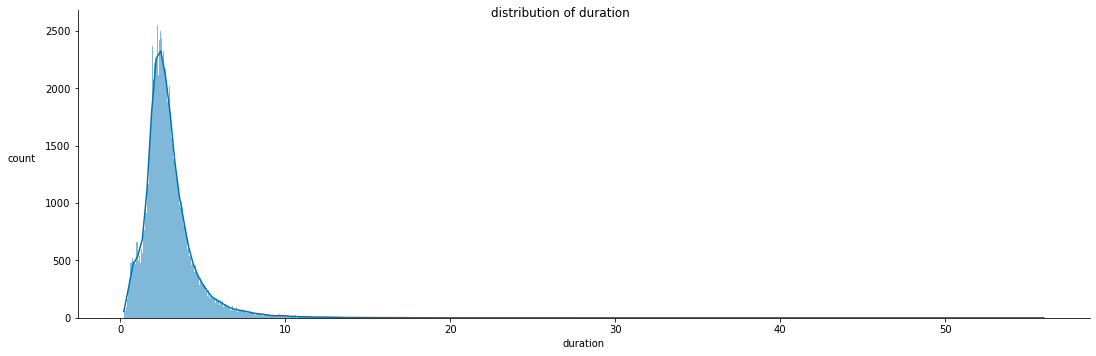

In [10]:
sns.displot(x=df.duration, kde=True, linewidth=0, aspect=3)
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.suptitle("distribution of duration")

That's a pointy peak and a long and skinny tail! Let's confirm with skew and kurtosis.

In [11]:
print("skew:", df.duration.skew())
print("kurtosis:", df.duration.kurtosis())

skew: 3.724261778671849
kurtosis: 41.10470749251345


According to [Bulmer as cited in Brown (2020)](https://brownmath.com/stat/shape.htm):

> If skewness is less than −1 or greater than +1, the distribution is highly skewed.

> A distribution with kurtosis >3 (excess kurtosis >0) is called leptokurtic.

(Recall that a normal distribution has a kurtosis of 3.)

We might thus say the distribution of duration is highly positively skewed and leptokurtic.

This isn't far off from what we might expect in natural human language. Intuitively, spoken communication units are brief in duration, but some people might take a really long time to finish a thought now and then.

Nevertheless, this presents problems for our current task. I have found that most time series classification techniques require sequences of equal length. Even if we were to convert the data to spectrograms now, the resulting images would have mismatched dimensions.

There are a couple of common approaches to address this issue:
* padding short sequences
  * pro: no information lost from trimming or distortion from shrinking/stretching
  * con: any signal reflected by actual silence in the audio may be confused, especially at the ends of the sequence where the padding takes place
* truncating long sequences
  * pro: no information is distorted or artificially added
  * con: you lose the information you truncate
* stretching short sequences
  * pro: you might consider this free data augmentation; if the discrepancy is marginal this transformation would be like slowing down the track a little
  * con: this distorts the signal
* shrinking long sequences
  * pro: you might consider this free data augmentation; if the discrepancy is marginal this transformation would be like speeding up the track a little
  * con: this distorts the signal
* hybrid approaches

Naturally, the greater the discrepancy betwen the shorter and longer sequences, the more signal will be lost/artifically added and the greater the distortion. That is to say, the degree to which information is lost/added/distorted by these transformations is limited by the maximum discrepancy between the shortest and longest durations. Therefore, to mitigate the degree to which this occurs, we can regroup the data by their durations.

In fact, from the boxplot below, you can see the inliers on the left, a cluster of outliers just beyond the whisker, and some scattered outliers that make up the long tail. It could make sense to ditch the longest ones and then separate the remainder into groups by duration.

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:xlabel='duration'>

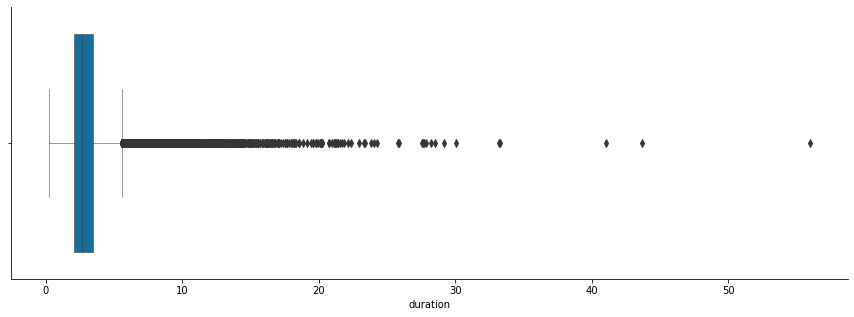

In [12]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=df.duration, linewidth=0.5)
despine_topright()

The question, then, is thus: How shall we sensibly regroup this data?

Before proceeding, let's visualize the distribution of duration with respect to other attributes so we get a better feel for the data.

## Additional visualization

[Skipped the cell's code and loaded variables p1, p11, p2, p22, p3, p33, p4, p44, p5, p55, p6, p66 from file 'c:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\notebooks\1.0-mic-divide-data-by-duration\displots.pkl'.]


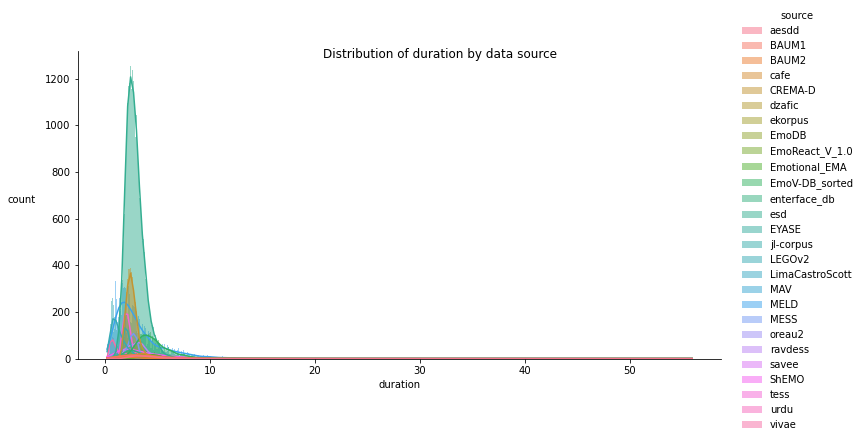

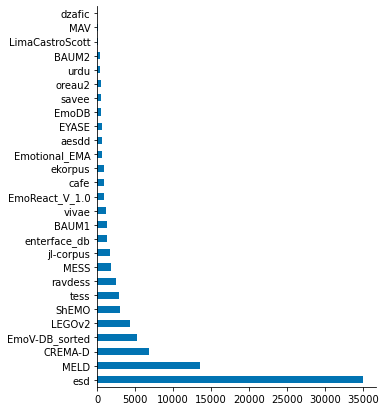

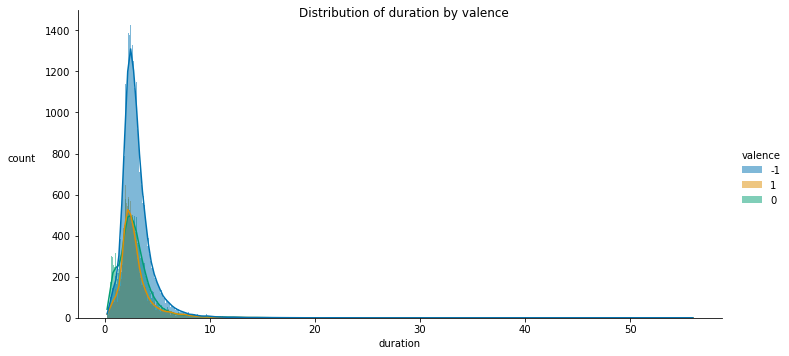

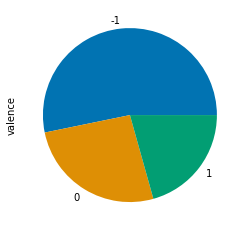

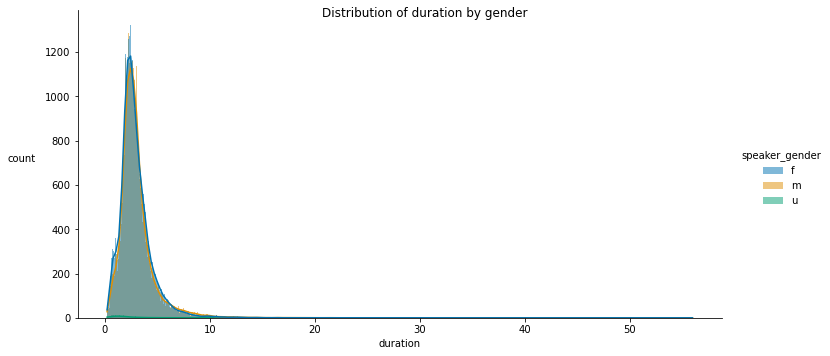

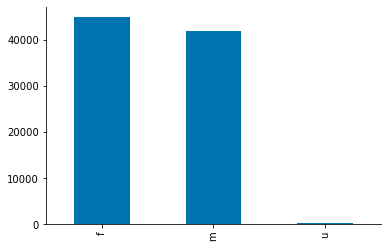

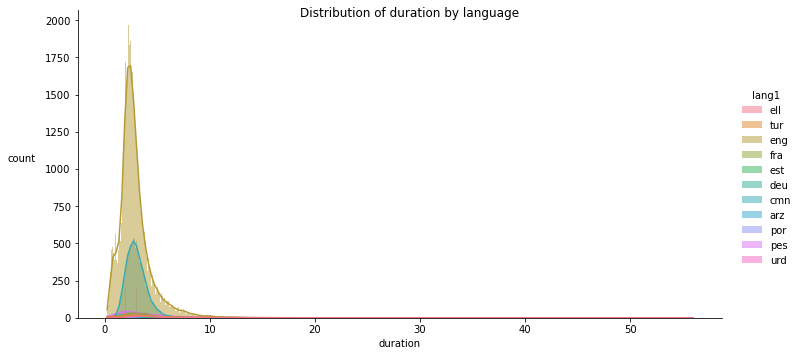

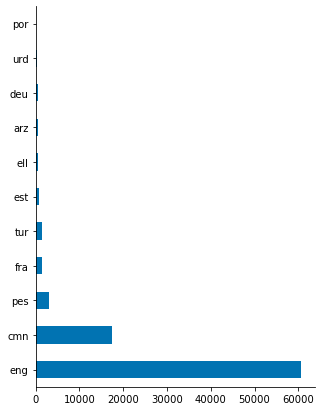

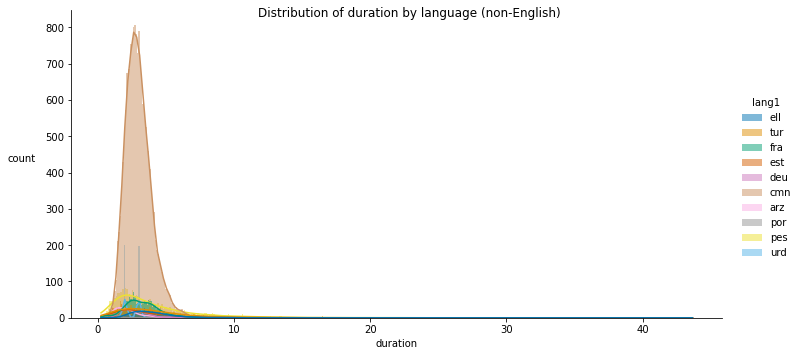

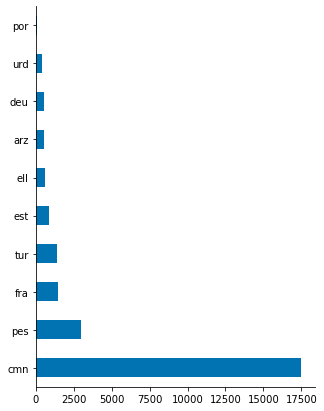

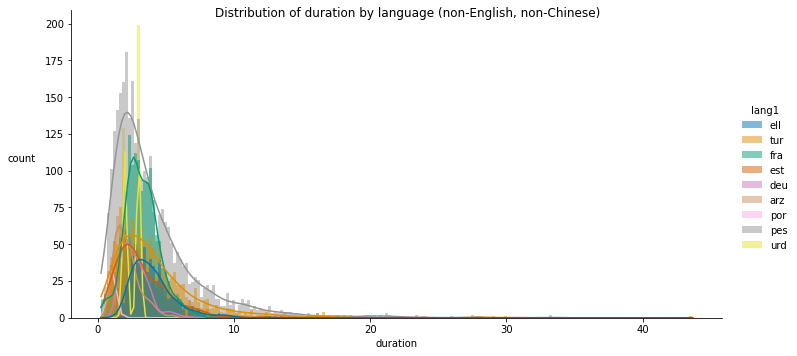

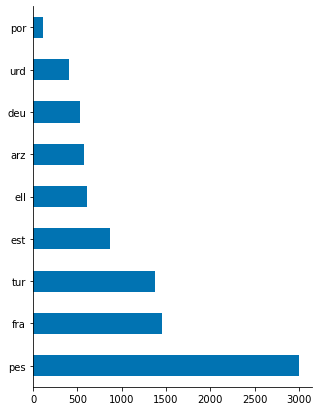

In [13]:
%%cache displots.pkl p1 p11 p2 p22 p3 p33 p4 p44 p5 p55 p6 p66

# source
p1 = sns.displot(x=df.duration, kde=True, linewidth=0, hue=df.source, aspect=2)
plt.suptitle("Distribution of duration by data source")
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.show()
(_ := df.source.value_counts())
plt.figure(figsize=(5, 7))
p11 = _.plot(kind="barh")
despine_topright()
plt.show()

# valence
p2 = sns.displot(x=df.duration, kde=True, linewidth=0, hue=df.valence, aspect=2)
plt.suptitle("Distribution of duration by valence")
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.show()
(_ := df.valence.value_counts())
p22 = _.plot(kind="pie")
plt.show()

# speaker_gender
p3 = sns.displot(x=df.duration, kde=True, linewidth=0, hue=df.speaker_gender, aspect=2)
plt.suptitle("Distribution of duration by gender")
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.show()
(_ := df.speaker_gender.value_counts())
p33 = _.plot(kind="bar")
despine_topright()
plt.show()

# lang1
p4 = sns.displot(x=df.duration, kde=True, linewidth=0, hue=df.lang1, aspect=2)
plt.suptitle("Distribution of duration by language")
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.show()
(_ := df.lang1.value_counts())
plt.figure(figsize=(5, 7))
p44 = _.plot(kind="barh")
despine_topright()
plt.show()

# lang1 no English
p5 = sns.displot(
    x=(df_non_english := df.loc[df.lang1 != "eng"]).duration,
    kde=True,
    linewidth=0,
    hue=df_non_english.lang1,
    aspect=2,
)
plt.suptitle("Distribution of duration by language (non-English)")
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.show()
(_ := df_non_english.lang1.value_counts())
plt.figure(figsize=(5, 7))
p55 = _.plot(kind="barh")
despine_topright()
plt.show()

# lang1 no English no Chinese
p6 = sns.displot(
    x=(df_non_english_non_chinese := df.loc[(df.lang1 !="eng")&(df.lang1 != "cmn")]).duration,
    kde=True,
    linewidth=0,
    hue=df_non_english_non_chinese.lang1,
    aspect=2,
)
plt.suptitle("Distribution of duration by language (non-English, non-Chinese)")
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.show()
(_ := df_non_english_non_chinese.lang1.value_counts())
plt.figure(figsize=(5, 7))
p66 = _.plot(kind="barh")
despine_topright()
plt.show()

It's hard to see details because of the wide variation in scale. Let's zoom in on the samples that exceed 15 seconds in duration and we will repeat those visualizations.

### Where duration exceeds 15 seconds

In [14]:
fifteen_plus = df.loc[df.duration > 15]

Text(0.5, 0.98, 'distribution of duration (> 15 s)')

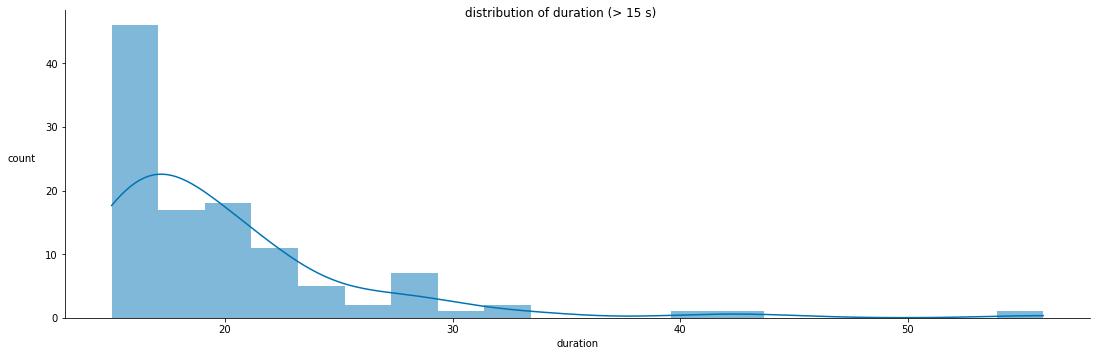

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:xlabel='duration'>

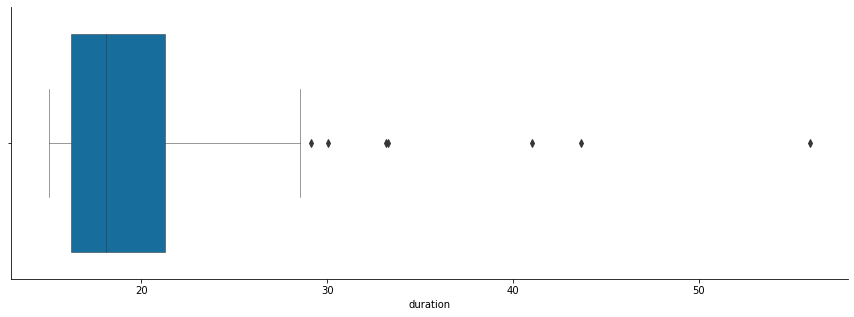

In [15]:
sns.displot(x=fifteen_plus.duration, kde=True, linewidth=0, aspect=3)
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.suptitle("distribution of duration (> 15 s)")
plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(x=fifteen_plus.duration, linewidth=0.5)
despine_topright()
plt.show()

[Skipped the cell's code and loaded variables p11_15, p1_15, p22_15, p2_15, p33_15, p3_15, p44_15, p4_15, p55, p5_15, p66_15, p6_15 from file 'c:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\notebooks\1.0-mic-divide-data-by-duration\displots_15.pkl'.]


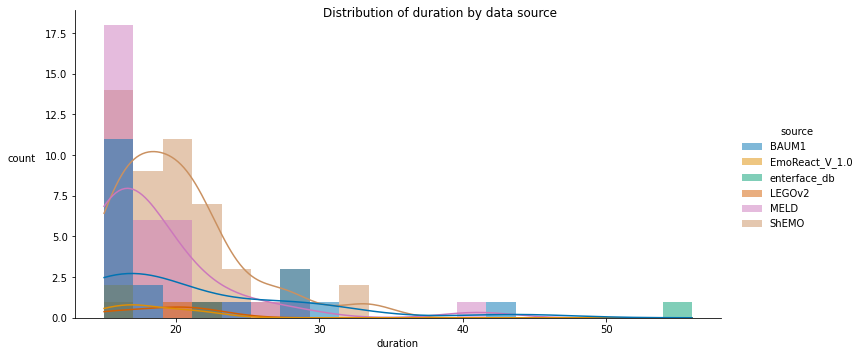

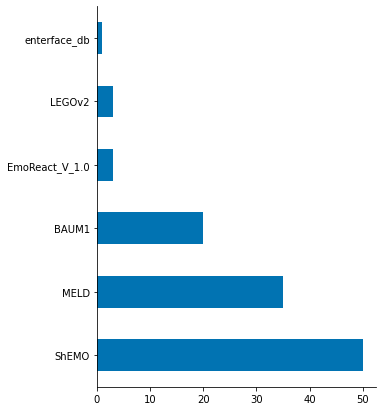

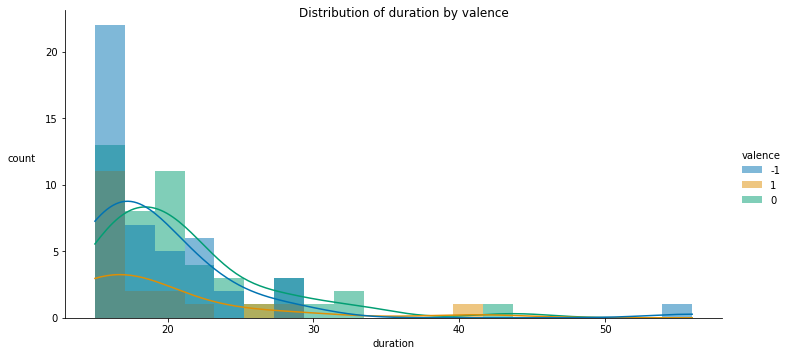

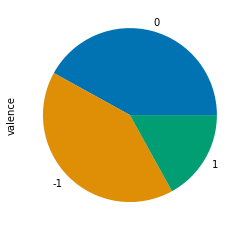

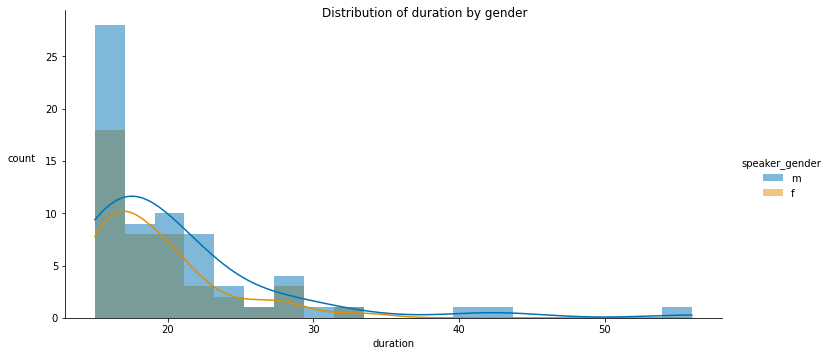

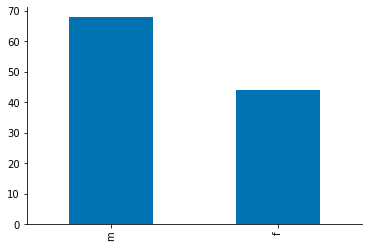

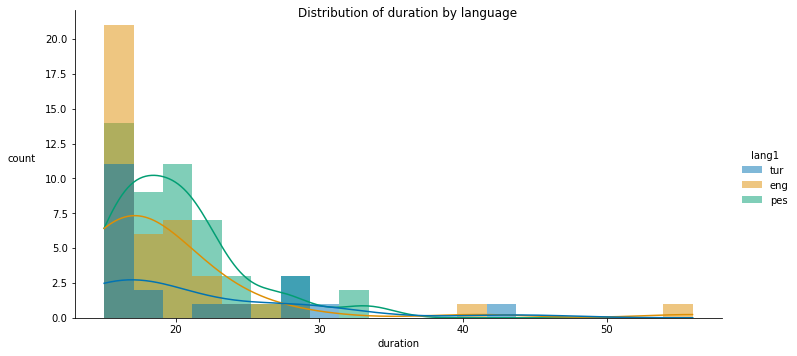

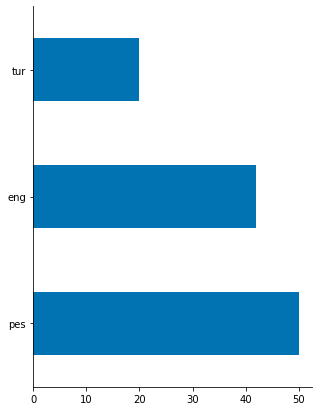

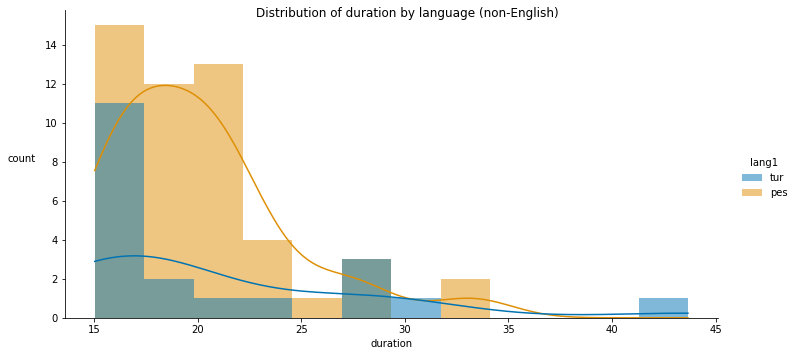

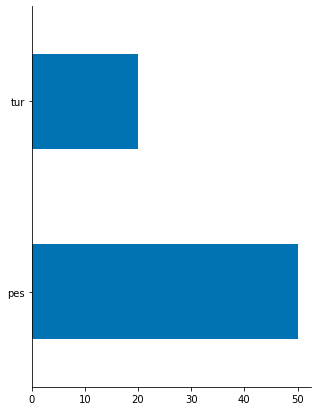

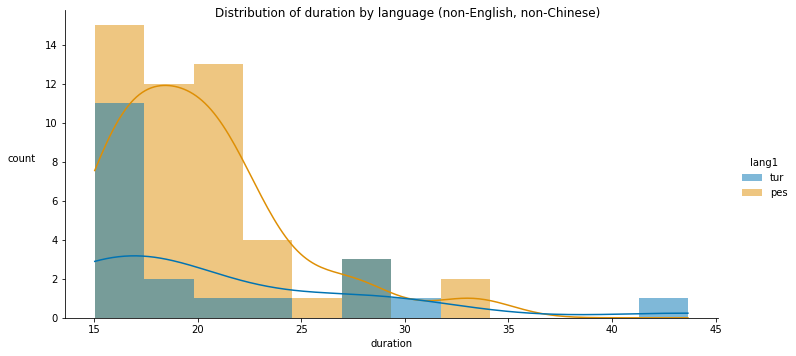

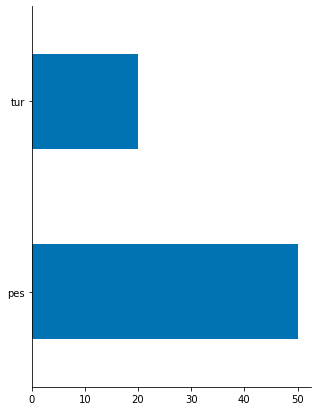

In [16]:
%%cache displots_15.pkl p1_15 p11_15 p2_15 p22_15 p3_15 p33_15 p4_15 p44_15 p5_15 p55 p6_15 p66_15

# source
p1_15 = sns.displot(x=(duration := fifteen_plus.duration), kde=True, linewidth=0, hue=fifteen_plus.source, aspect=2)
plt.suptitle("Distribution of duration by data source")
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.show()
(_ := fifteen_plus.source.value_counts())
plt.figure(figsize=(5, 7))
p11_15 = _.plot(kind="barh")
despine_topright()
plt.show()

# valence
p2_15 = sns.displot(x=duration, kde=True, linewidth=0, hue=fifteen_plus.valence, aspect=2)
plt.suptitle("Distribution of duration by valence")
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.show()
(_ := fifteen_plus.valence.value_counts())
p22_15 = _.plot(kind="pie")
plt.show()

# speaker_gender
p3_15 = sns.displot(x=duration, kde=True, linewidth=0, hue=fifteen_plus.speaker_gender, aspect=2)
plt.suptitle("Distribution of duration by gender")
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.show()
(_ := fifteen_plus.speaker_gender.value_counts())
p33_15 = _.plot(kind="bar")
despine_topright()
plt.show()

# lang1
p4_15 = sns.displot(x=duration, kde=True, linewidth=0, hue=fifteen_plus.lang1, aspect=2)
plt.suptitle("Distribution of duration by language")
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.show()
(_ := fifteen_plus.lang1.value_counts())
plt.figure(figsize=(5, 7))
p44_15 = _.plot(kind="barh")
despine_topright()
plt.show()

# lang1 no English
p5_15 = sns.displot(
    x=(df_non_english15 := fifteen_plus.loc[fifteen_plus.lang1 != "eng"]).duration,
    kde=True,
    linewidth=0,
    hue=df_non_english15.lang1,
    aspect=2,
)
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.suptitle("Distribution of duration by language (non-English)")
plt.show()
(_ := df_non_english15.lang1.value_counts())
plt.figure(figsize=(5, 7))
p55_15 = _.plot(kind="barh")
despine_topright()
plt.show()

# lang1 no English no Chinese
p6_15 = sns.displot(
    x=(df_non_english_non_chinese15 := fifteen_plus.loc[(fifteen_plus.lang1 !="eng") & (fifteen_plus.lang1 != "cmn")]).duration,
    kde=True,
    linewidth=0,
    hue=df_non_english_non_chinese15.lang1,
    aspect=2,
)
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.suptitle("Distribution of duration by language (non-English, non-Chinese)")
plt.show()
(_ := df_non_english_non_chinese15.lang1.value_counts())
plt.figure(figsize=(5, 7))
p66_15 = _.plot(kind="barh")
despine_topright()
plt.show()

## Isolation forest

Let's begin by using isolation forest to examine ostensible outliers.

In [17]:
def plot_IF_duration(
    df: pd.DataFrame,
    contamination="auto",
    suppress=False,
    return_xxliers=True,
) -> Union[tuple, None]:
    """Given a dataframe with durations, plot outlier region(s) and return inlier and outlier dataframes."""
    """Return None if the input df is empty."""
    if len(df) == 0:
        return None
    fitted_IF = IsolationForest(
        contamination=contamination, n_jobs=-1, random_state=SEED
    ).fit(df[["duration"]])
    if not suppress:
        plt.figure(figsize=(10, 5))
        plt.plot(
            sampler := np.linspace(
                df.duration.min(), df.duration.max(), len(df)
            ).reshape(-1, 1),
            anomaly_score := fitted_IF.decision_function(sampler),
            label="anomaly score",
        )
        plt.fill_between(
            sampler.T[0],
            anomaly_score.min(),
            anomaly_score.max(),
            where=fitted_IF.predict(sampler) == -1,
            color="r",
            alpha=0.3,
            label="outlier region",
        )

        plt.axvline(x=df.duration.mean(), color="blue", linewidth=0.5, label="mean")

        plt.legend()
        plt.ylabel("anomaly\nscore", labelpad=10, ha="right").set_rotation(0)
        plt.xlabel("duration")
        despine_topright()

        plt.show()
    # return inliers, outliers
    df["outlier"] = fitted_IF.predict(df[["duration"]])
    inliers, outliers = df.loc[df.outlier == 1], df.loc[df.outlier == -1]
    df = df.drop("outlier", axis=1)
    return (
        (inliers.drop("outlier", axis=1), outliers.drop("outlier", axis=1))
        if return_xxliers
        else None
    )

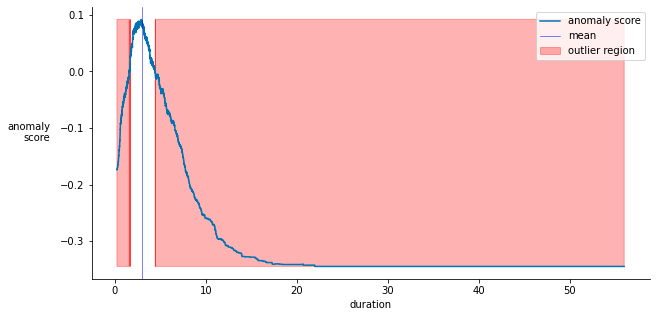

In [18]:
plot_IF_duration(df, return_xxliers=False)

The plot above reveals a contiguous region of outliers less than the mean duration, a contiguous region of inliers, and a contiguous region of outliers greater than the mean duration. This suggests that dividing the dataset into short, medium, and long durations may be appropriate.

### Remove the longest

Before deciding on such a division, let's remove the longest clips first. These have low face validity for single utterances.

To do so, isolation forest can help us identify which are anomalously long and could possibly be marked for omission.  Because we only want to remove the very longest, we can split the distribution at the mean first. To conservatively mark data for omission, we can choose a low contamination rate.

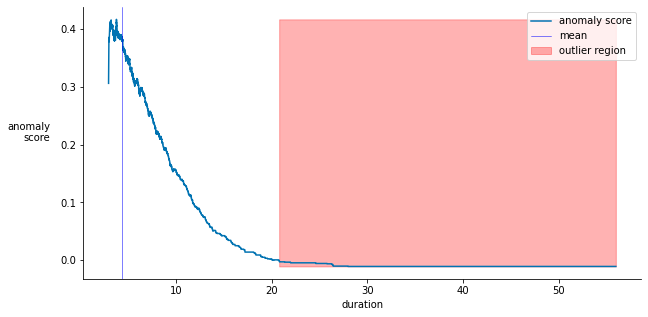

In [19]:
lo, hi = (
    df.loc[df.duration <= df.duration.mean()],
    df.loc[df.duration > df.duration.mean()],
)
plot_IF_duration(hi, contamination=0.001, return_xxliers=False)

The outlier region is all greater than the mean. One way to approach this is to discard the outlier region, and run isolation forest on the reduced region iteratively until there is an outlier region on either side of the mean. Due to the contamination rate of 0.001, we might expect 0.1% of the long files to be removed each iteration until the condition is met. Let's give it a shot.

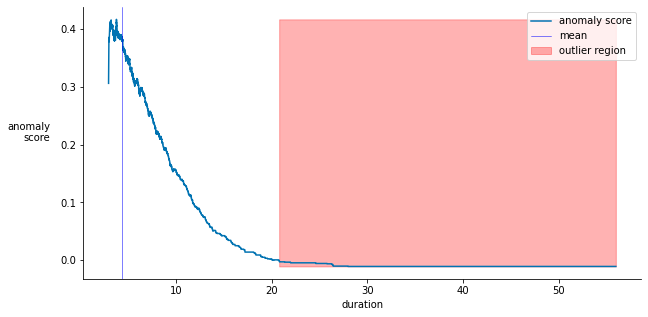

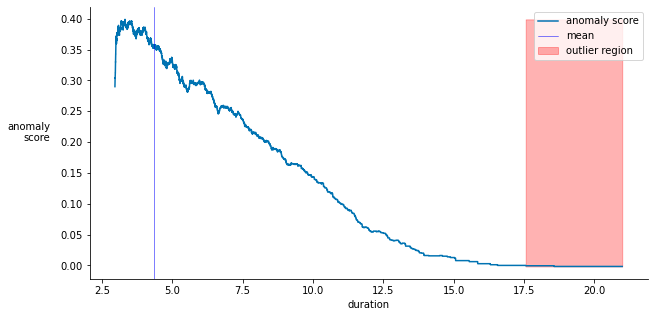

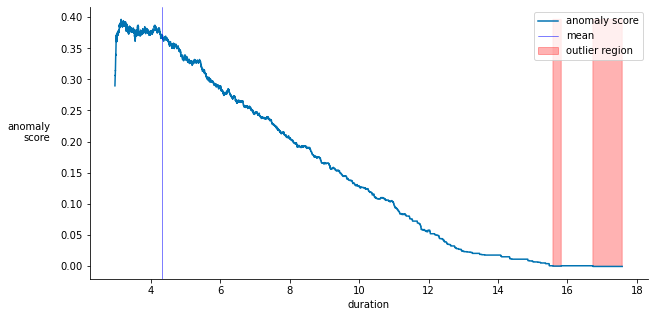

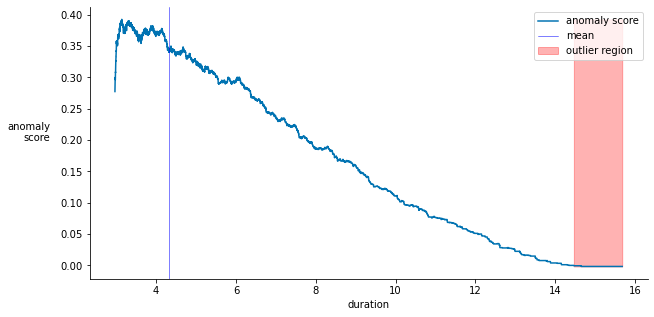

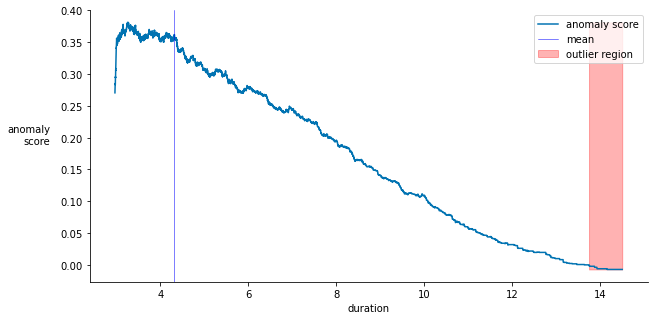

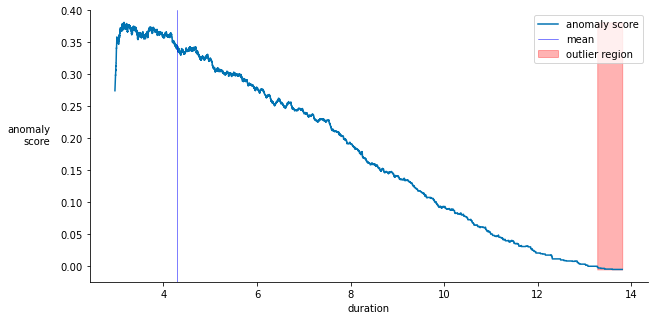

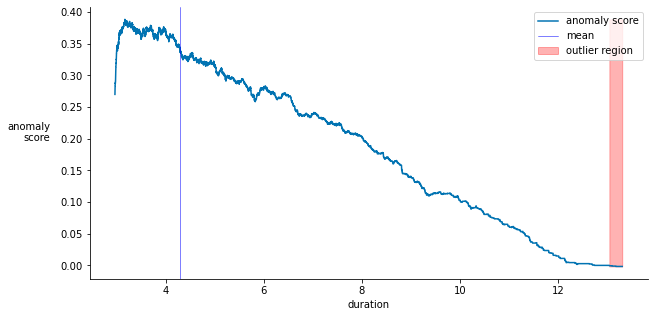

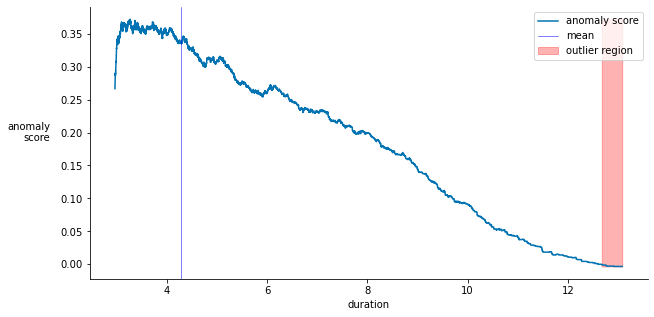

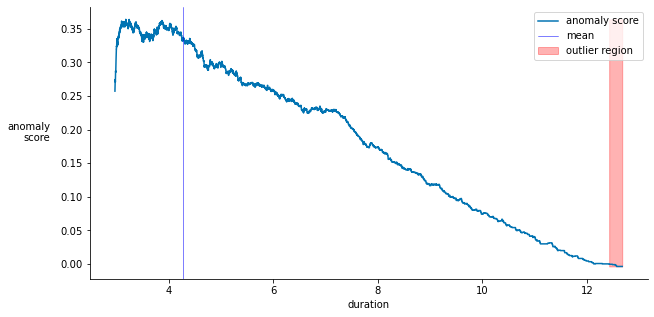

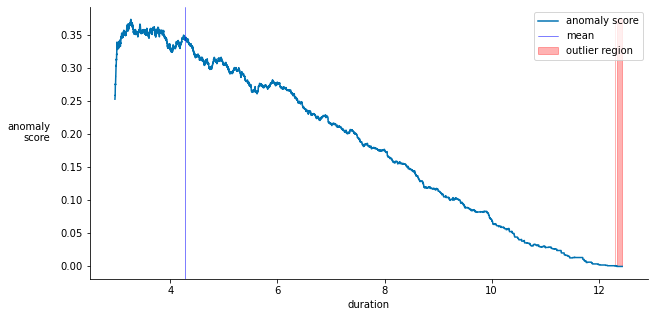

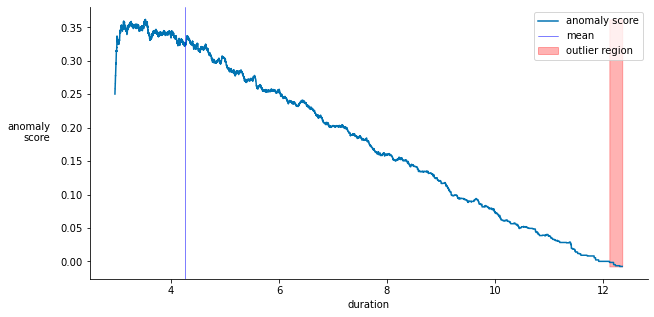

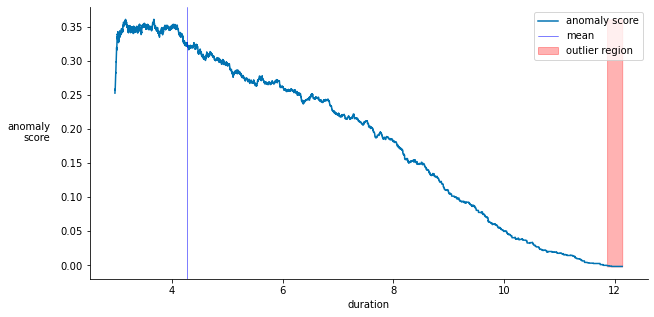

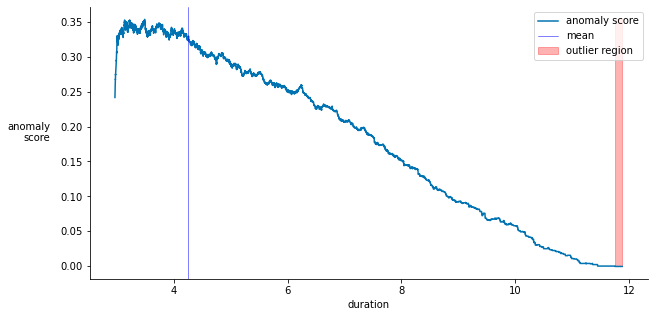

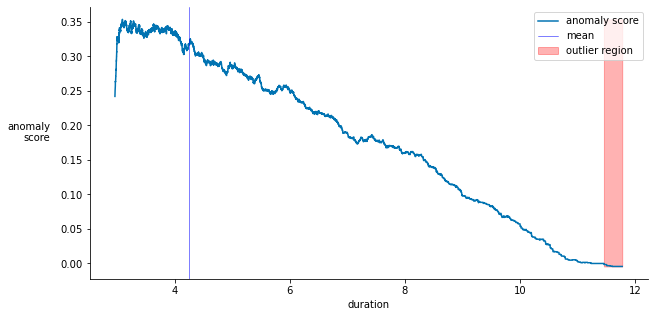

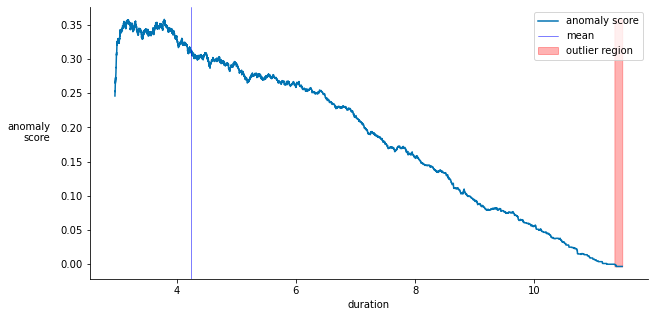

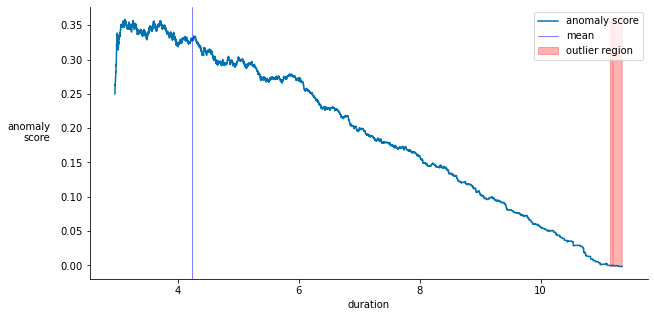

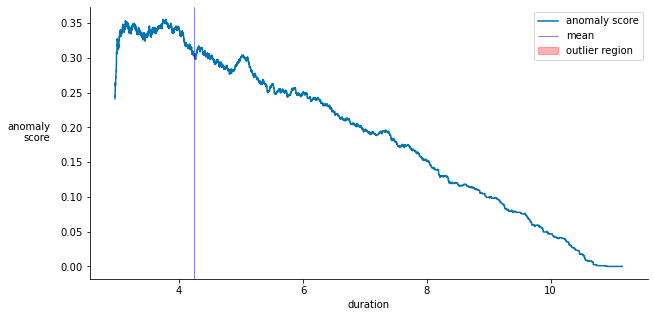

no outliers


In [20]:
new_hi = hi.copy()
contam = 0.001
inliers, outliers = plot_IF_duration(new_hi, contamination=contam, suppress=False)
while (low_thresh := outliers.duration.min()) > new_hi.duration.mean():
    new_hi = new_hi.loc[new_hi.duration <= low_thresh]
    inliers, outliers = plot_IF_duration(new_hi, contamination=contam, suppress=False)
    if len(outliers) == 0:
        print("no outliers")
        break

In [21]:
len(lo)
len(new_hi)
len(hi) - len(new_hi)
(cutoff := new_hi.duration.max())

53480

33272

394

11.1539375

It looks like we didn't lose too many! Let's investigate what we have marked to discard.

In [22]:
to_discard = df.loc[df.duration > new_hi.duration.max()]
to_discard.duration.describe()

count    394.000000
mean      14.714826
std        4.777774
min       11.160000
25%       12.018750
50%       13.087500
75%       15.521250
max       55.960000
Name: duration, dtype: float64

Text(0.5, 0.98, 'distribution of duration (to discard)')

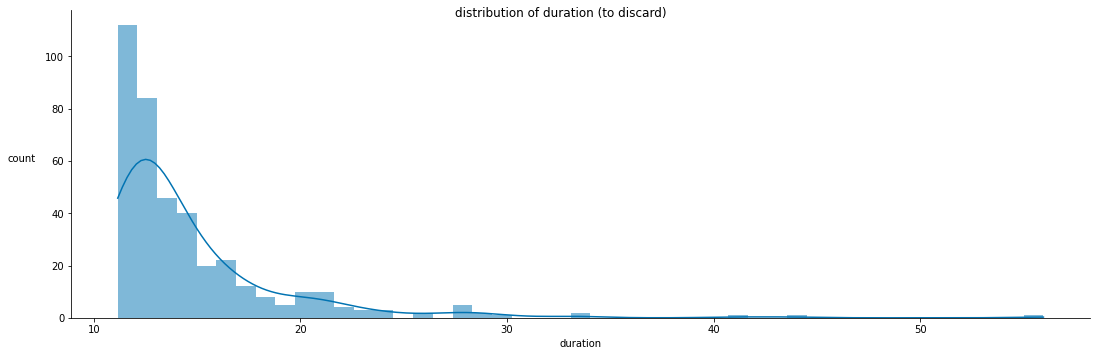

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:xlabel='duration'>

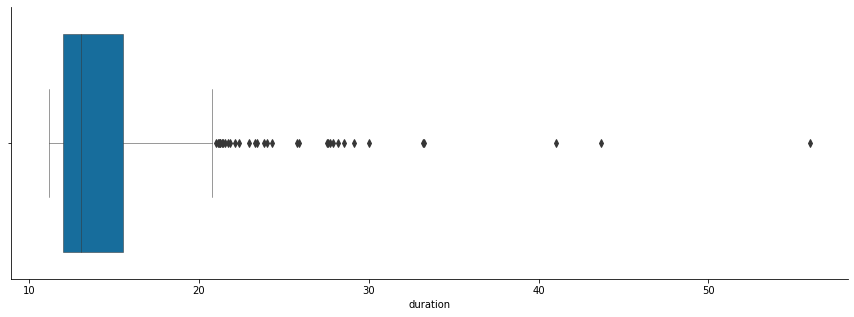

In [23]:
sns.displot(x=to_discard.duration, kde=True, linewidth=0, aspect=3)
plt.suptitle("distribution of duration (to discard)")
plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(x=to_discard.duration, linewidth=0.5)
despine_topright()
plt.show()

In [24]:
to_discard.source.value_counts()
to_discard.lang1.value_counts()
to_discard.speaker_gender.value_counts()
to_discard.valence.value_counts()
to_discard.emo.value_counts()

MELD              174
ShEMO             124
BAUM1              54
EmoReact_V_1.0     16
LEGOv2             12
EmoV-DB_sorted      5
ekorpus             4
BAUM2               2
aesdd               1
enterface_db        1
savee               1
Name: source, dtype: int64

eng    210
pes    124
tur     55
est      4
ell      1
Name: lang1, dtype: int64

m    228
f    164
u      2
Name: speaker_gender, dtype: int64

-1    162
0     157
1      75
Name: valence, dtype: int64

neu    157
sad     58
hap     51
ang     50
unk     16
unc     15
sur     13
dis     11
fea      7
bot      6
con      5
amu      4
bor      1
Name: emo, dtype: int64

In [25]:
for source in to_discard.source.value_counts().index:
    f"{(100*len(to_discard.loc[to_discard.source == source]))/len(df.loc[df.source == source]):3f}% of {source}"

'1.284891% of MELD'

'4.133333% of ShEMO'

'4.316547% of BAUM1'

'1.707577% of EmoReact_V_1.0'

'0.282819% of LEGOv2'

'0.096674% of EmoV-DB_sorted'

'0.461361% of ekorpus'

'0.576369% of BAUM2'

'0.165563% of aesdd'

'0.077640% of enterface_db'

'0.205339% of savee'

In [26]:
for lang in to_discard.lang1.value_counts().index:
    f"{(100*len(to_discard.loc[to_discard.lang1 == lang]))/len(df.loc[df.lang1 == lang]):3f}% of {lang}"

'0.345935% of eng'

'4.133333% of pes'

'3.988397% of tur'

'0.461361% of est'

'0.165563% of ell'

In [27]:
for gender_code in to_discard.speaker_gender.value_counts().index:
    f"{(100*len(to_discard.loc[to_discard.speaker_gender == gender_code]))/len(df.loc[df.speaker_gender == gender_code]):3f}% of {gender_code}"

'0.543504% of m'

'0.365378% of f'

'0.643087% of u'

In [28]:
for emo in to_discard.emo.value_counts().index:
    f"{(100*len(to_discard.loc[to_discard.emo == emo]))/len(df.loc[df.emo == emo]):3f}% of {emo}"

'0.703973% of neu'

'0.470245% of sad'

'0.371179% of hap'

'0.305157% of ang'

'2.033037% of unk'

'8.333333% of unc'

'0.127488% of sur'

'0.270803% of dis'

'0.213871% of fea'

'6.818182% of bot'

'5.376344% of con'

'0.300075% of amu'

'0.763359% of bor'

In [29]:
for valence in to_discard.valence.value_counts().index:
    f"{(100*len(to_discard.loc[to_discard.valence == valence]))/len(df.loc[df.valence == valence]):3f}% of {valence}"

'0.349273% of -1'

'0.689504% of 0'

'0.416806% of 1'

This technique appeared to work okay here, but it's a little bit of a bummer to lose so many Persian and Turkish samples. We're losing 8.3% of uncertain, 6.8% of bothered, and 5.4% of contempt - some of our less common negative emotions. The class imbalance in valence is slightly exacerbated.

My hunch is that this approach is highly sensitive to the contamination rate chosen: set too high, you lose too much data; set too low, you keep more than you should.

In [30]:
cutoff

11.1539375

At any rate, I'm okay with the cutoff where it is at ~11.2 seconds. It's hard to imagine someone going on so long in one breath without introducing many separable communication units.

In [31]:
trimmed_df = df.loc[df.duration <= cutoff]

### Divvy data by duration

We can also use isolation forest to help us divide the retained data into short, medium, and long sequences. We can split the data into a short half and long half again. Using a similar approach, we can find a threshold to split each half once more. Then we can join the two inner halves for the medium set two would be the short and long.

First, let's split at the mean.

In [32]:
lo, hi = (
    trimmed_df.loc[trimmed_df.duration < trimmed_df.duration.mean()],
    trimmed_df.loc[trimmed_df.duration >= trimmed_df.duration.mean()],
)
len(lo)
len(hi)

51993

34759

#### Long

Let's tackle the upper half first. Like before, we will iterate until there are outliers on both sides of the mean or none detected at all.

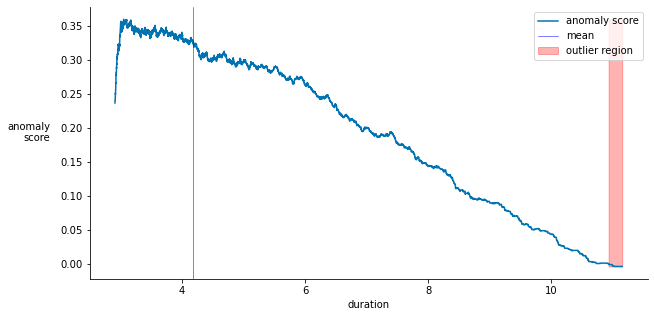

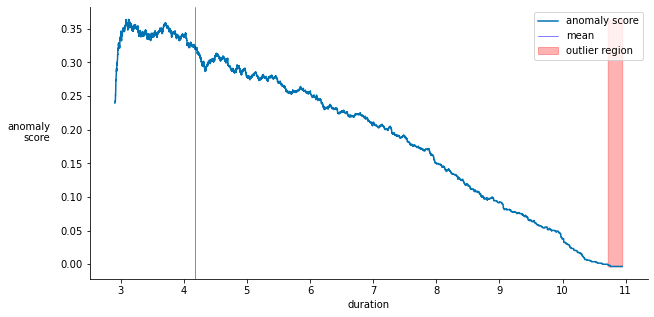

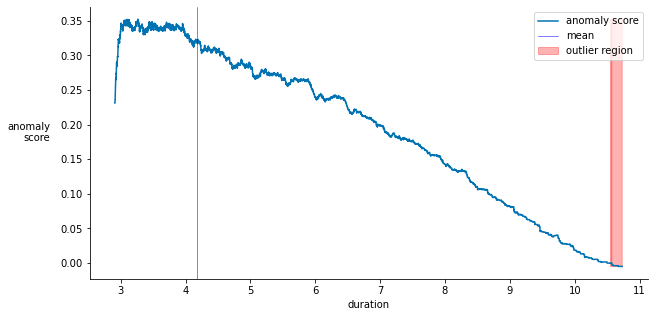

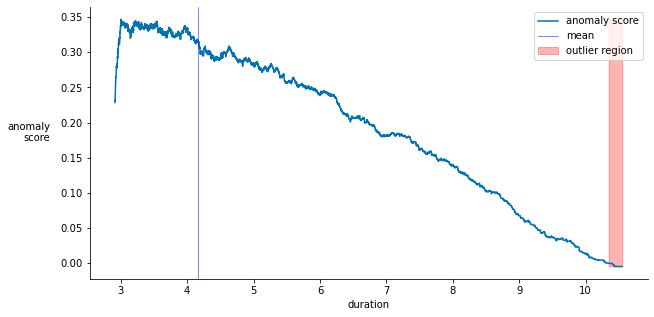

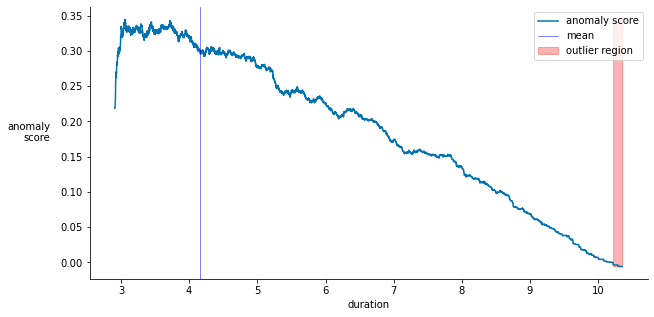

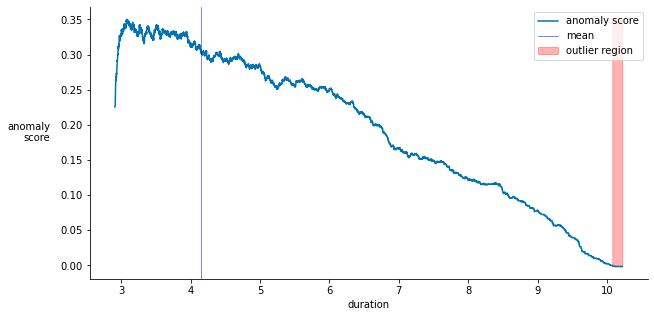

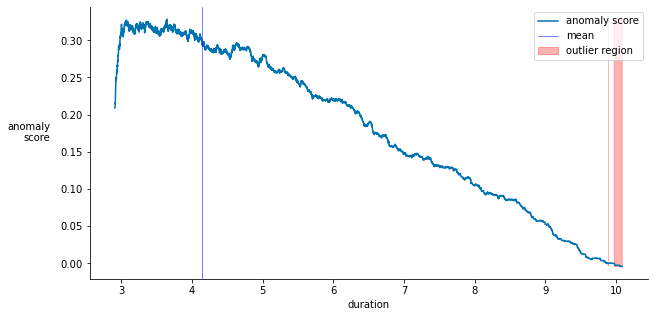

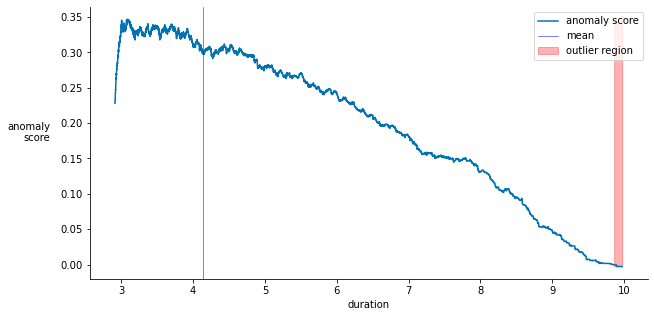

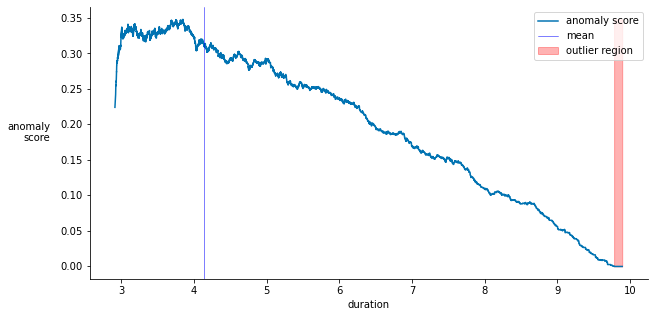

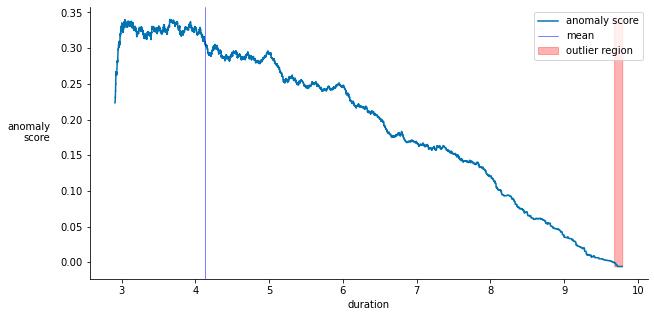

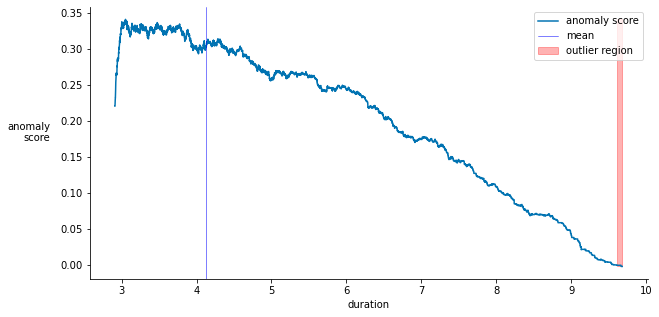

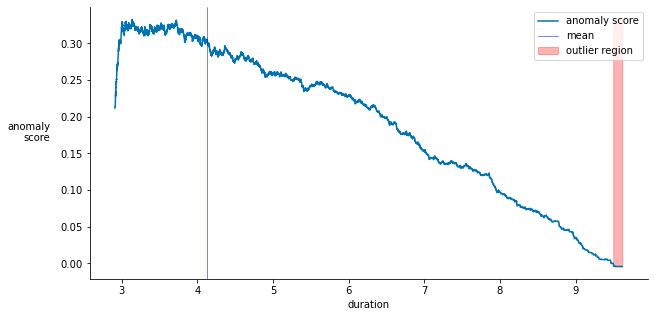

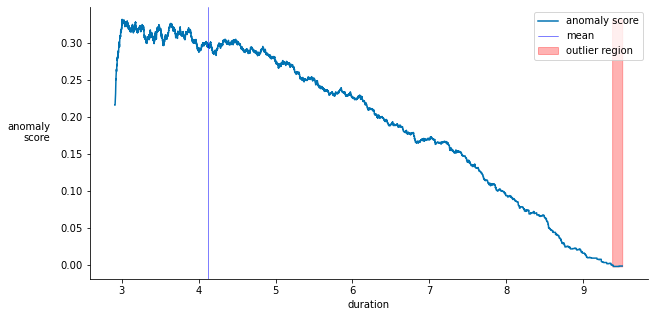

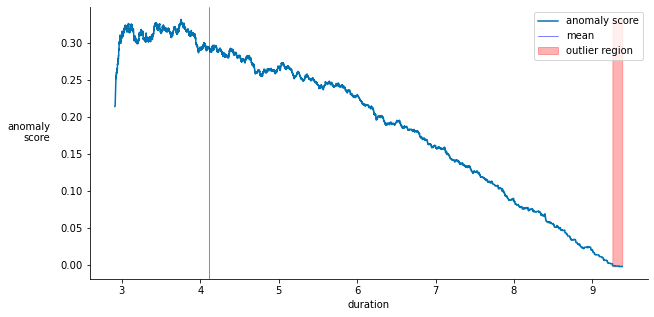

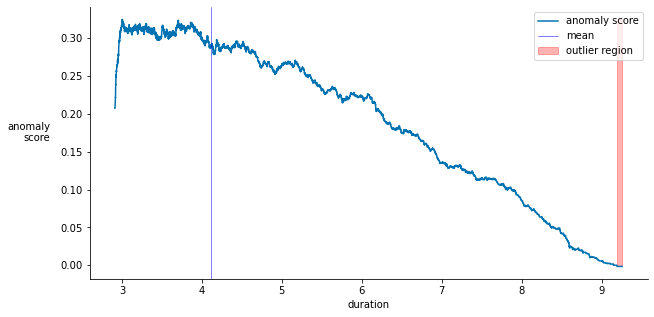

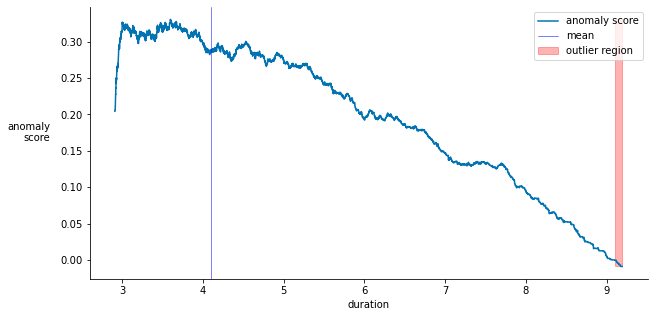

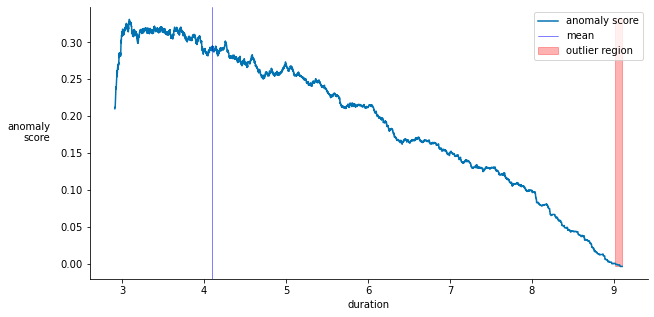

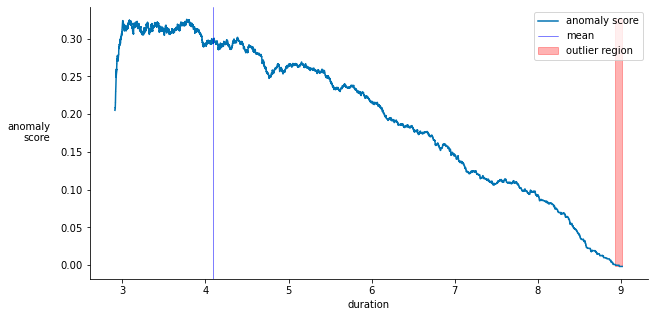

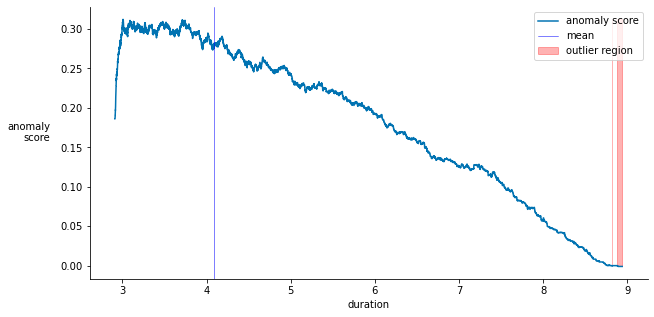

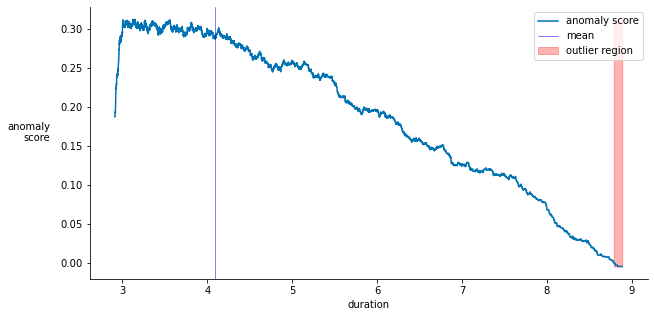

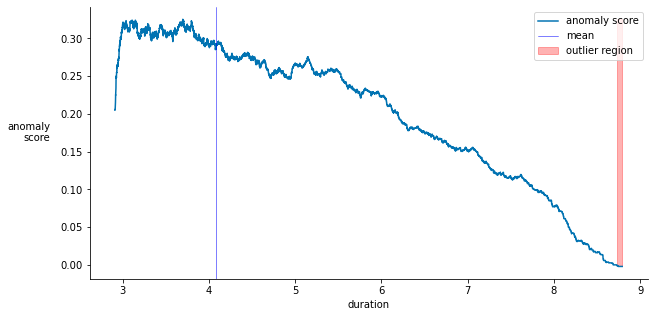

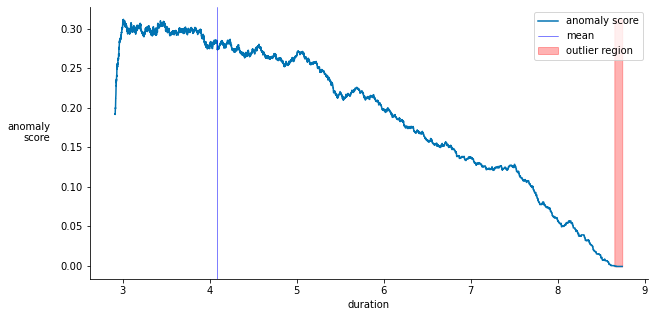

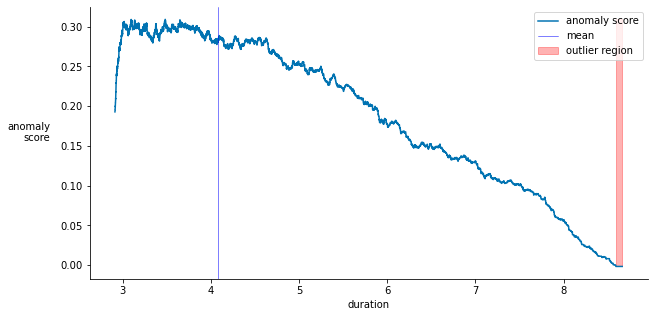

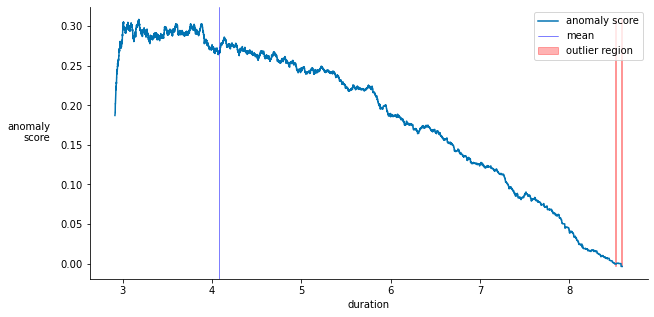

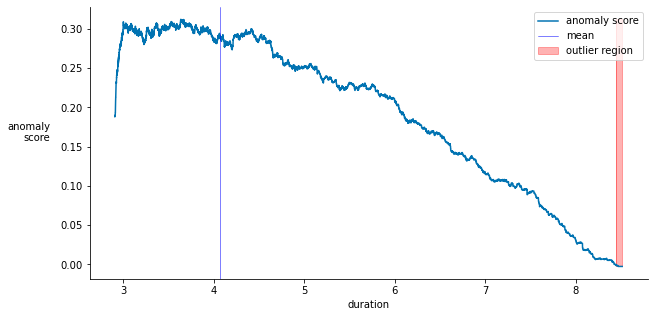

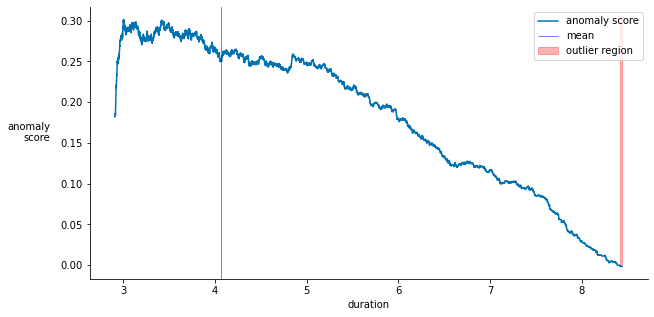

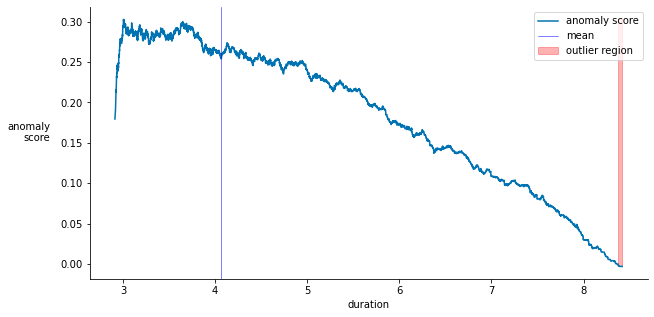

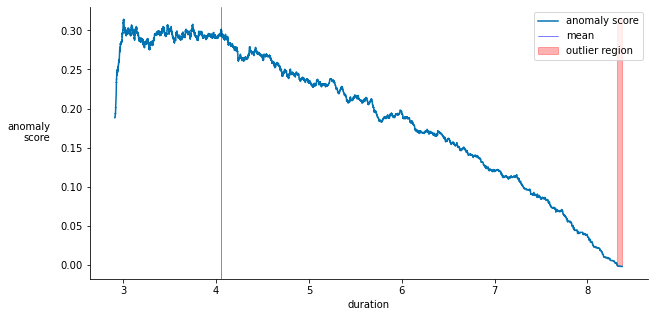

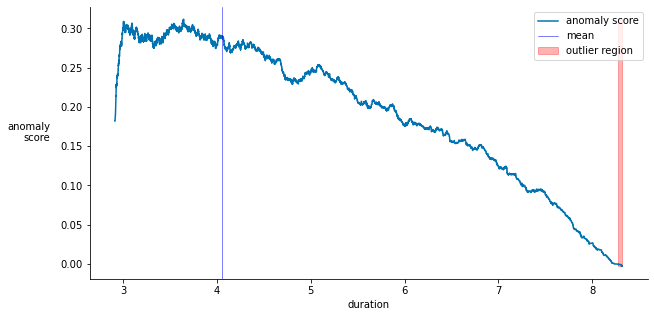

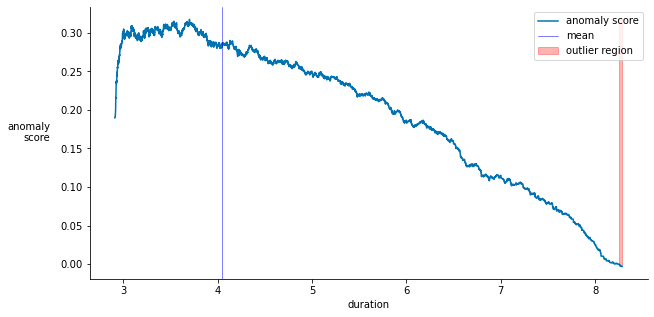

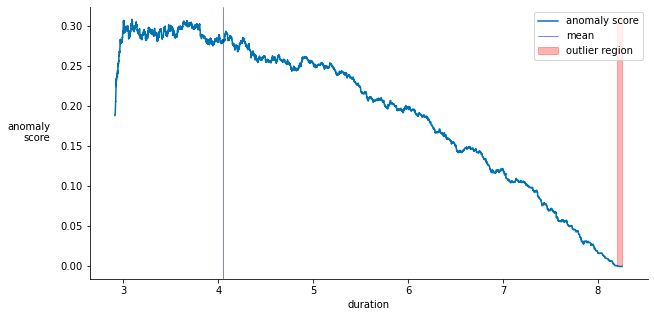

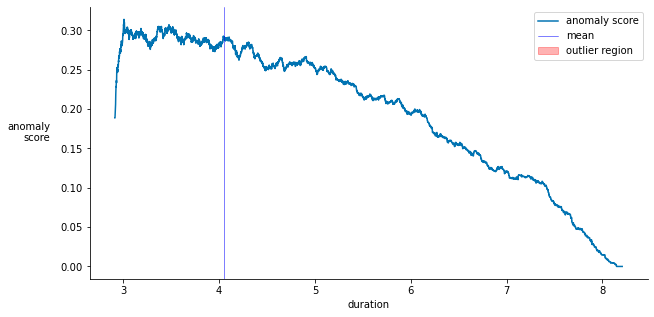

no outliers


In [33]:
# this cell is copy and pasted literatim from earlier
new_hi = hi.copy()
contam = 0.001
inliers, outliers = plot_IF_duration(new_hi, contamination=contam, suppress=False)
while (low_thresh := outliers.duration.min()) > new_hi.duration.mean():
    new_hi = new_hi.loc[new_hi.duration <= low_thresh]
    inliers, outliers = plot_IF_duration(new_hi, contamination=contam, suppress=False)
    if len(outliers) == 0:
        print("no outliers")
        break

In [34]:
(threshold_hi := new_hi.duration.max())
long = trimmed_df.loc[trimmed_df.duration >= threshold_hi]
long.duration.max()
len(long)

8.207

11.1539375

893

The long set has 893 samples ranging from 8.21 s to 11.15 s in duration.

Now let's do the short set.

#### Short

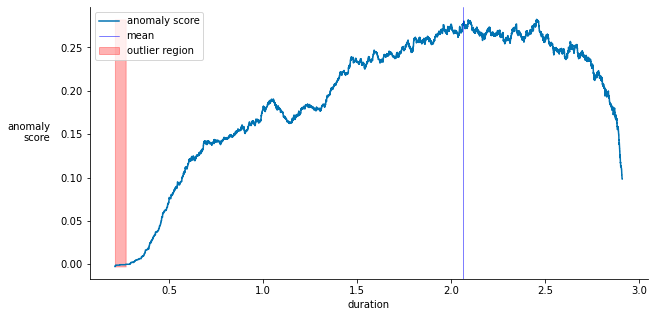

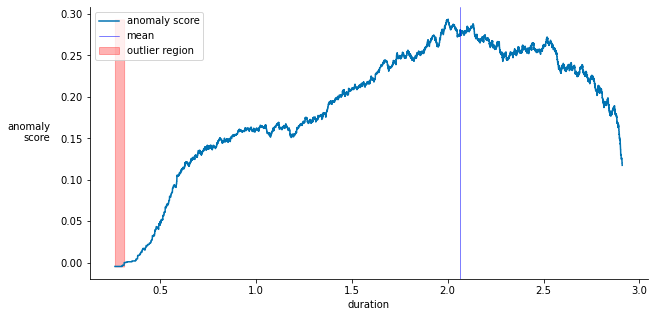

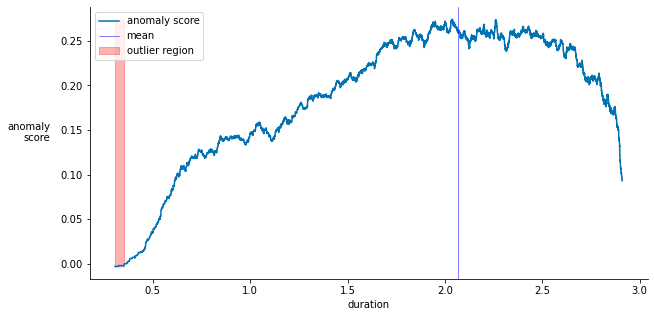

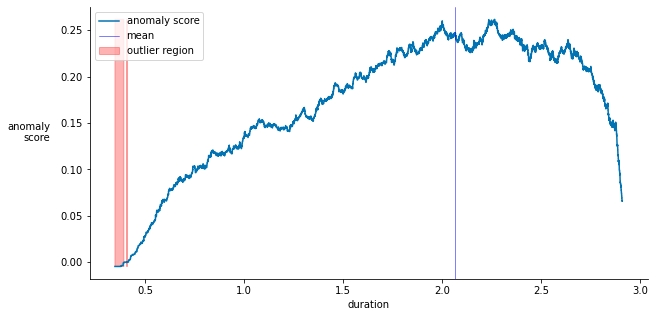

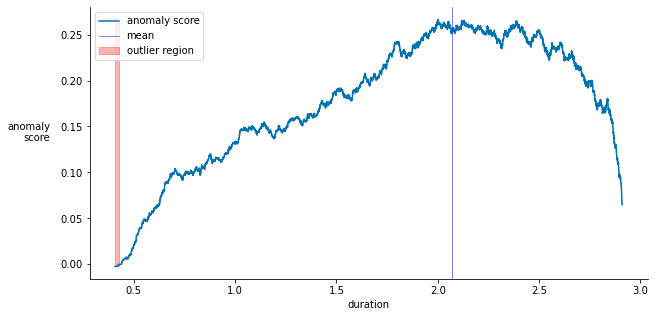

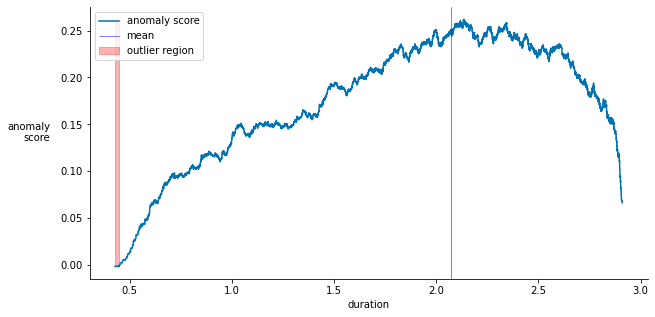

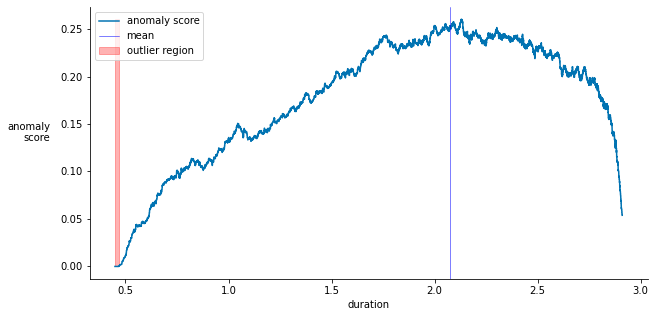

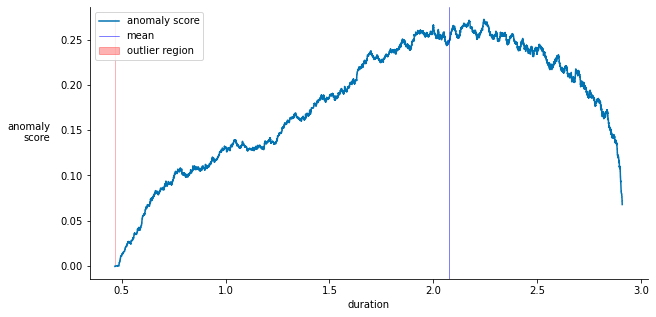

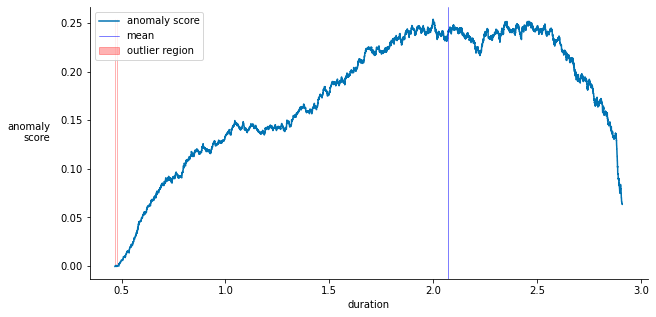

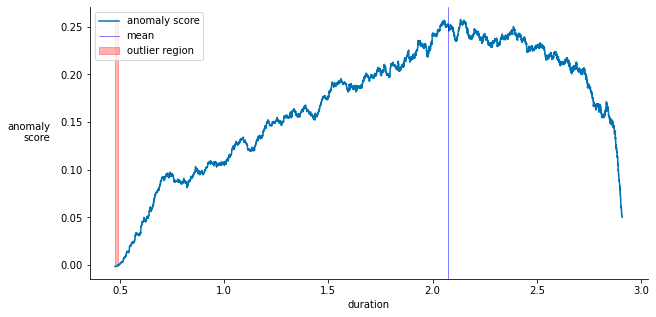

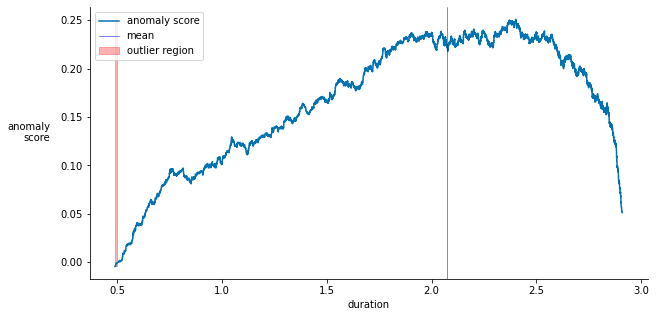

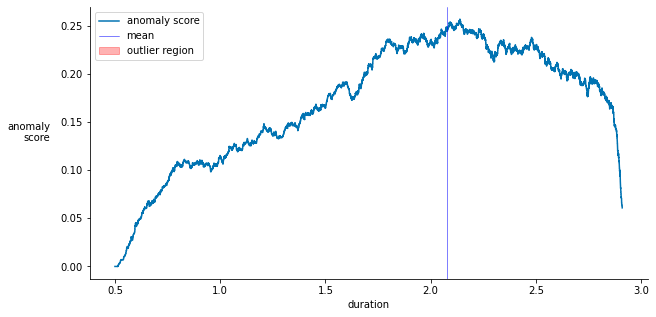

no outliers


In [35]:
new_lo = lo.copy()
contam = 0.001
inliers, outliers = plot_IF_duration(new_lo, contamination=contam, suppress=False)
while (high_thresh := outliers.duration.max()) < new_lo.duration.mean():
    new_lo = new_lo.loc[new_lo.duration >= high_thresh]
    inliers, outliers = plot_IF_duration(new_lo, contamination=contam, suppress=False)
    if len(outliers) == 0:
        print("no outliers")
        break

In [36]:
threshold_lo = new_lo.duration.min()
short = trimmed_df.loc[trimmed_df.duration <= threshold_lo]
short.duration.min()
threshold_lo
len(short)

0.213

0.5

480

The short set has 480 samples ranging from 0.2 s to 0.5 s in duration.

Now let's "reassemble" the medium set.

#### Medium

In [37]:
medium = trimmed_df.loc[
    (threshold_lo < trimmed_df.duration) & (trimmed_df.duration < threshold_hi)
]
medium.duration.min()
medium.duration.max()
len(medium)

0.501

8.195

85379

We retain the bulk of our data in the medium set, which ranges from 0.5 s to 8.2 s in duration and contains 85,379 samples.

In [38]:
trimmed_df["length"] = np.select(
    (
        trimmed_df.duration <= threshold_lo,
        (threshold_lo < trimmed_df.duration) & (trimmed_df.duration < threshold_hi),
        trimmed_df.duration >= threshold_hi,
    ),
    ("short", "medium", "long"),
)
trimmed_df.length.value_counts()

medium    85379
long        893
short       480
Name: length, dtype: int64

#### Tweak

Let's take a quick look at the new distributions.

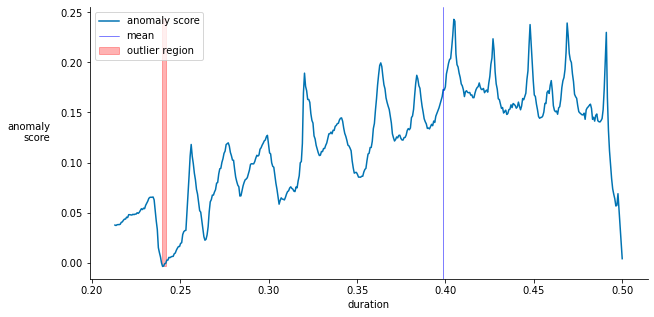

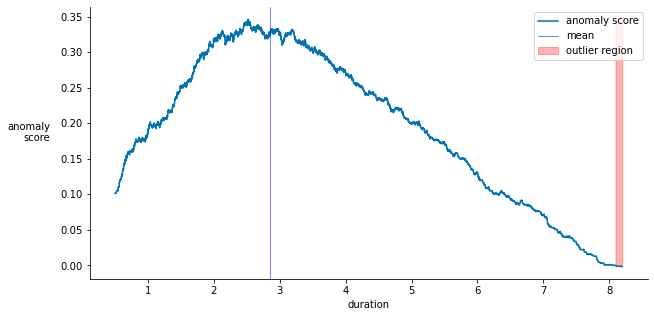

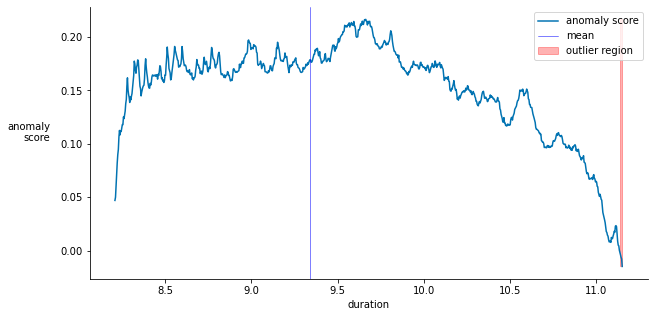

In [39]:
contam = 0.001
plot_IF_duration(short, contamination=contam, return_xxliers=False)
plot_IF_duration(medium, contamination=contam, return_xxliers=False)
plot_IF_duration(long, contamination=contam, return_xxliers=False)

The short set and long set have some anomalous regions near the shorter and longer ends respectively. We might assume that well-separated groups would only have anomalous regions at the borders they share with another group, so this is unsurprising.

On the other hand, the medium set only has an anomalous region in its high ranges, which is unsatisfying. Moreover, a range of durations between ~0.5 s and 8 s has low face validity: it's just too wide to pass the gut check.

We can use isolation forest to keep tweaking the medium set until we see anomalous regions at both ends of the distribution. I have the most data in the medium set, so I'm choosing to bump up the contamination rate from 0.001 to 0.0015 (but to be frank, I spent some time hand-tuning this parameter).

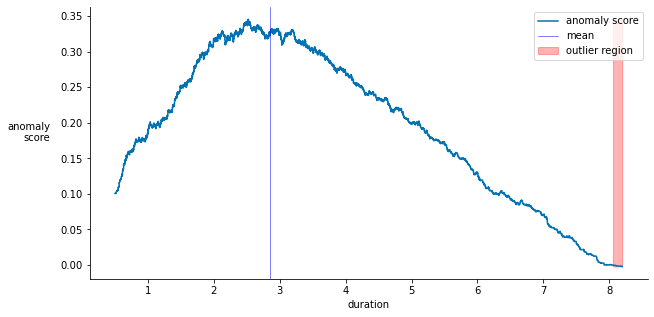

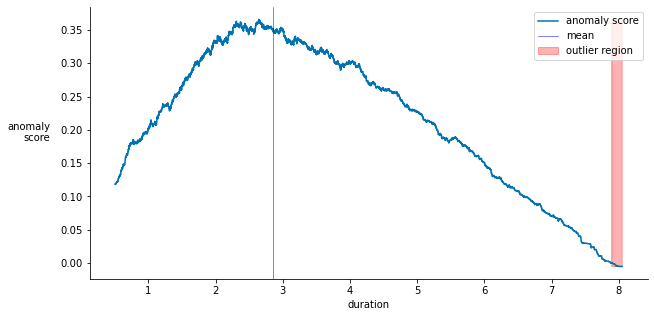

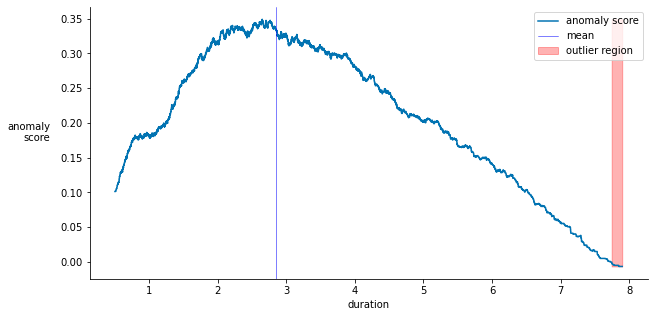

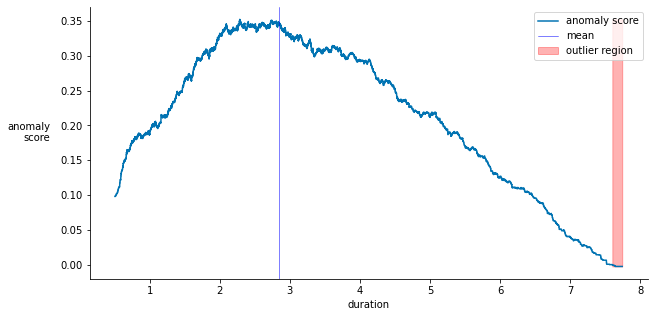

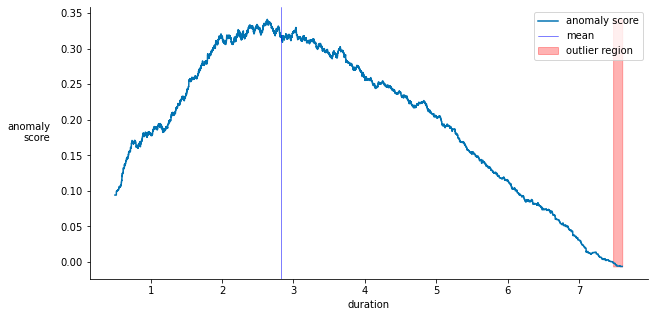

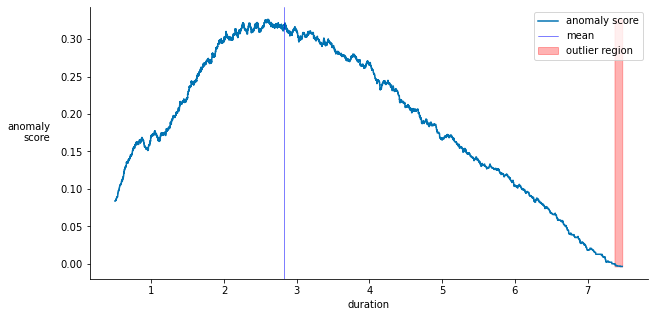

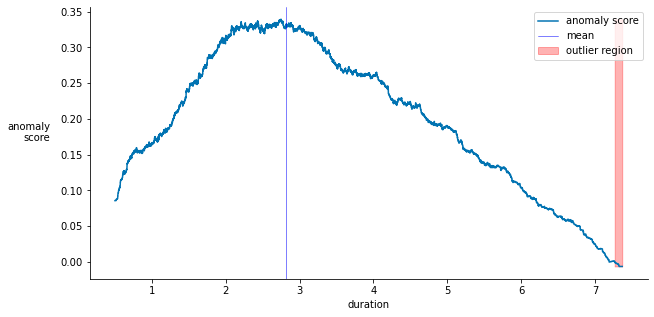

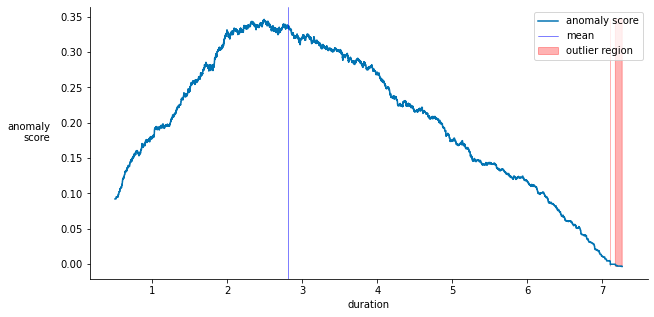

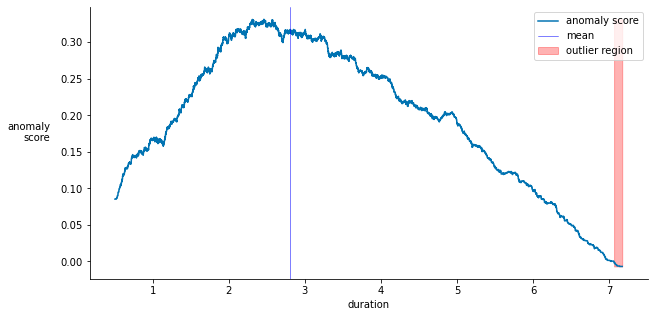

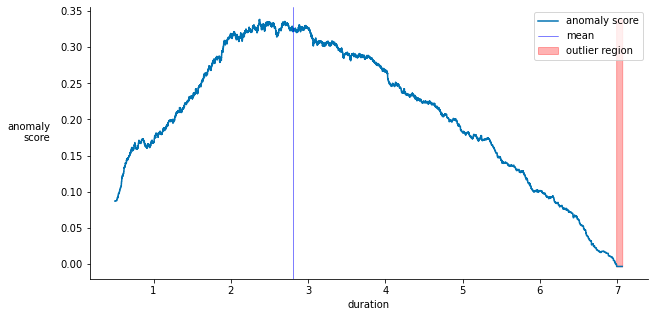

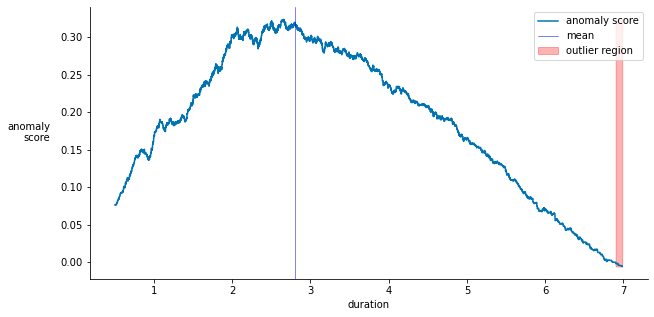

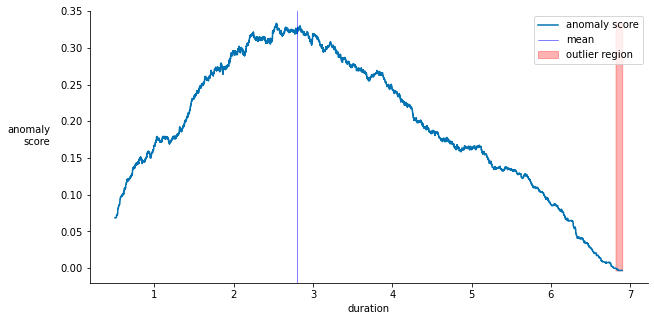

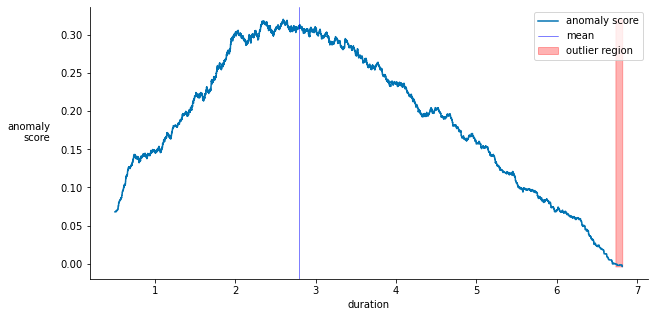

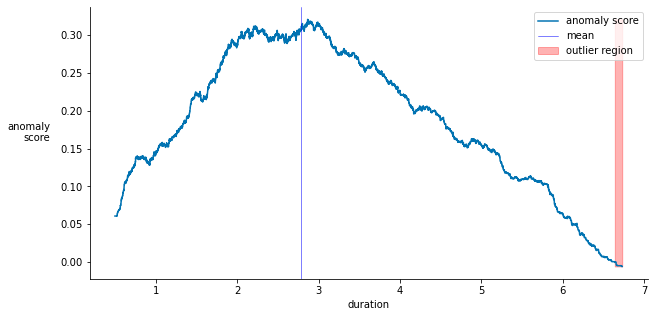

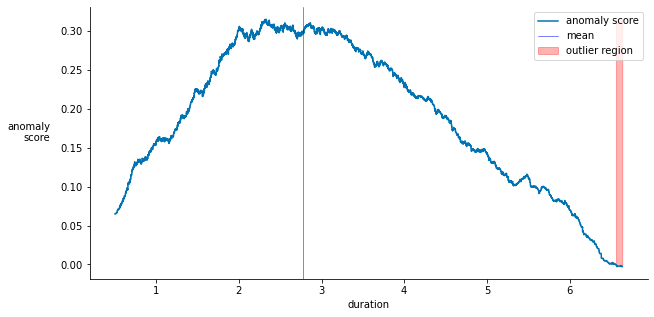

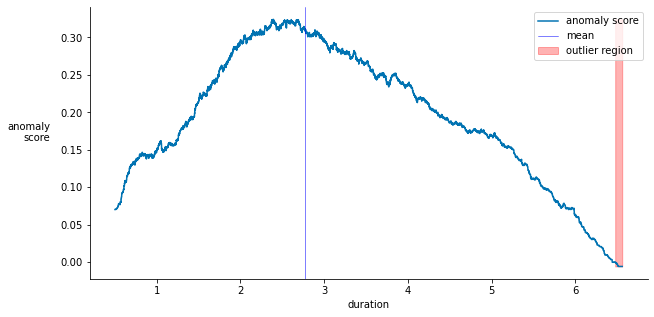

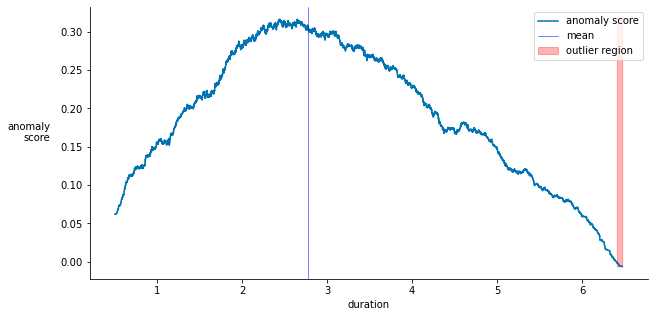

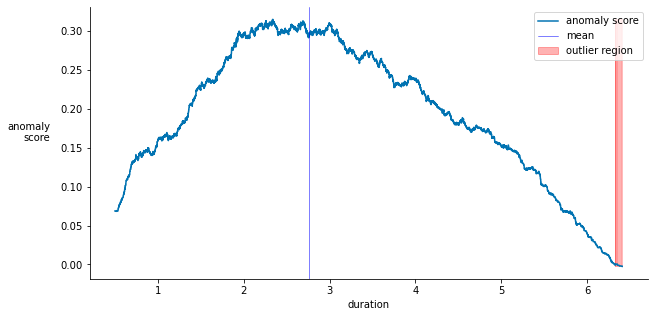

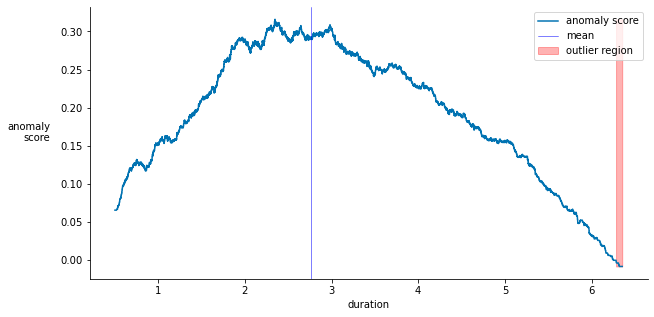

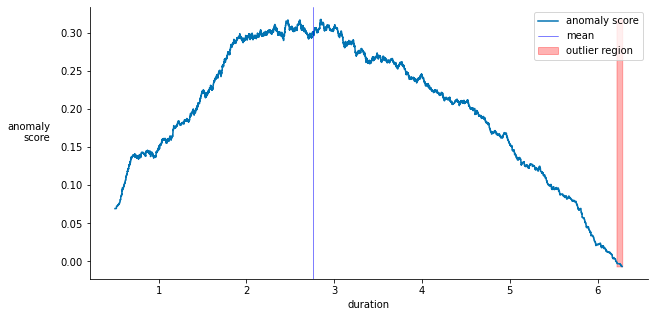

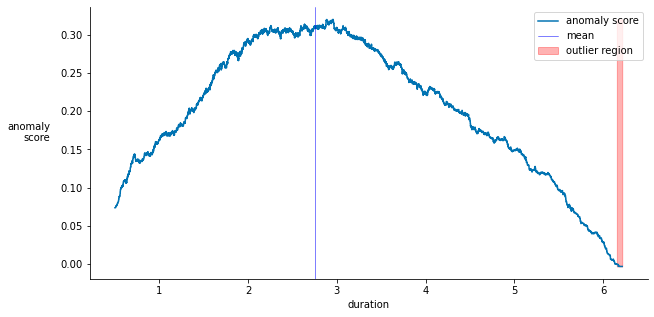

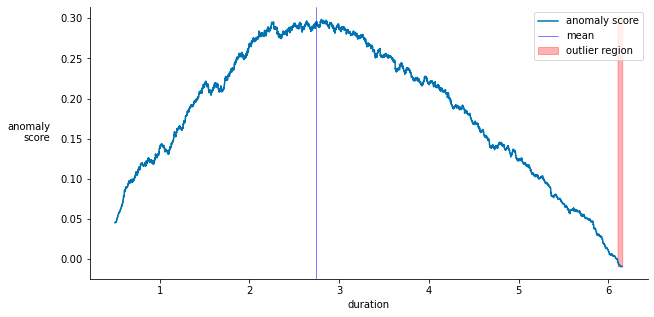

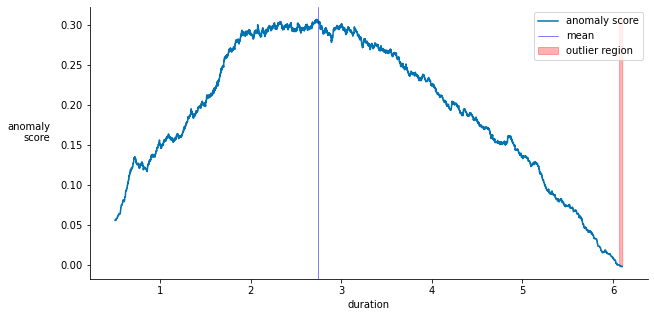

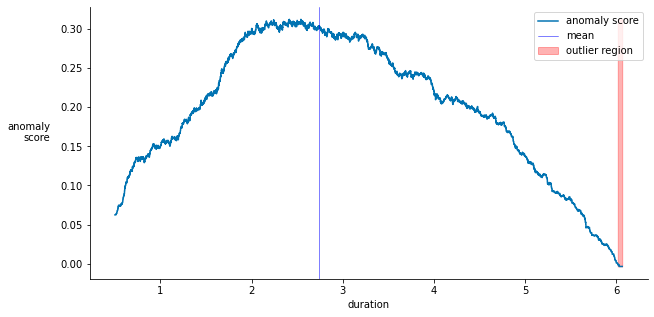

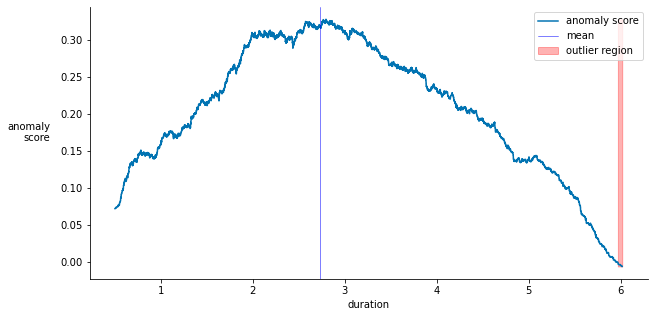

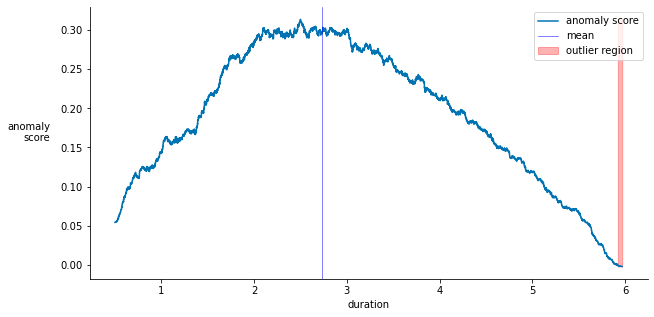

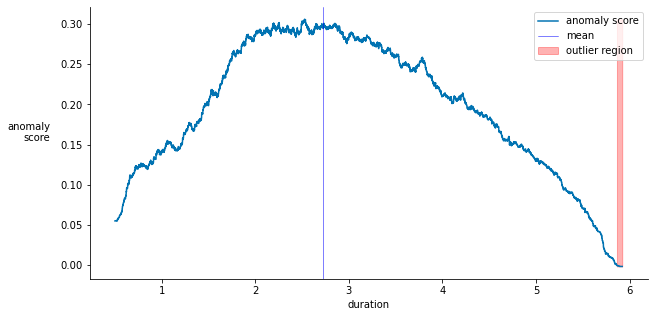

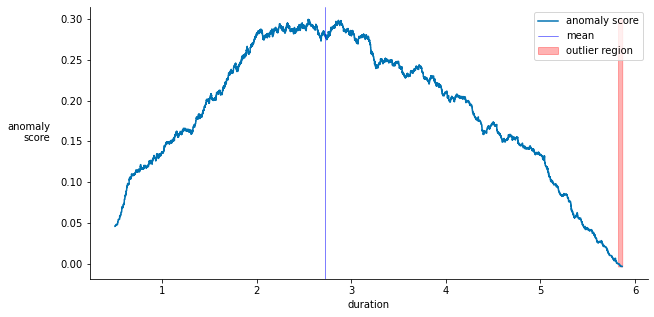

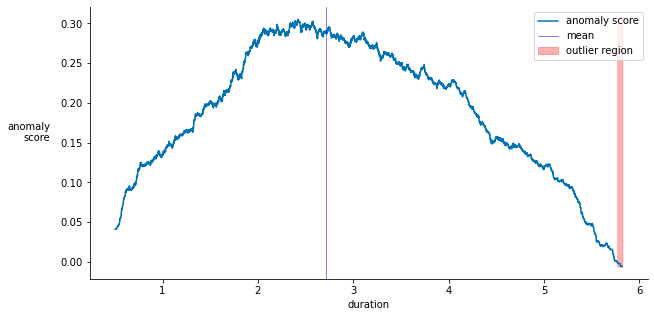

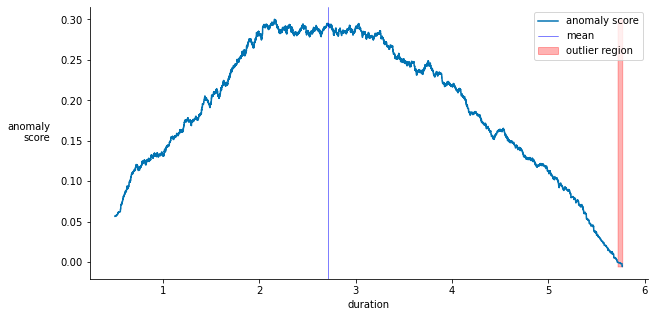

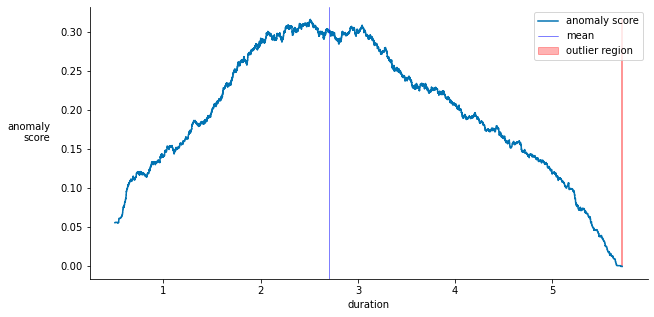

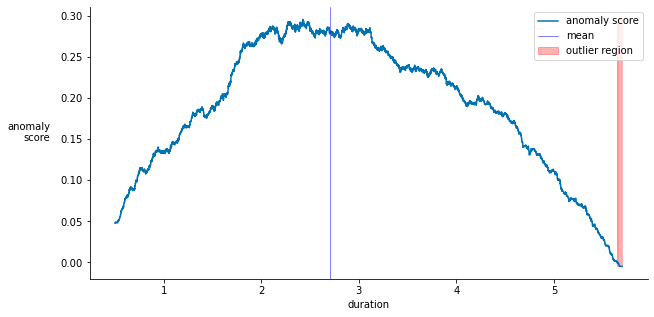

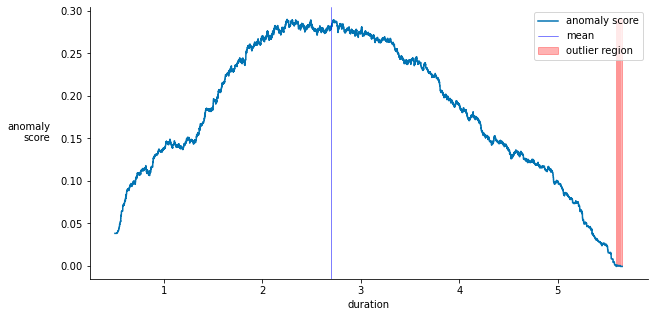

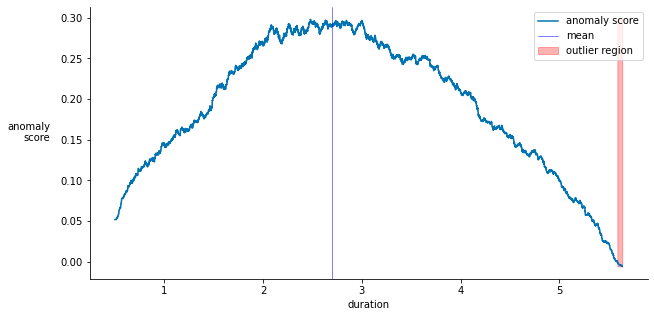

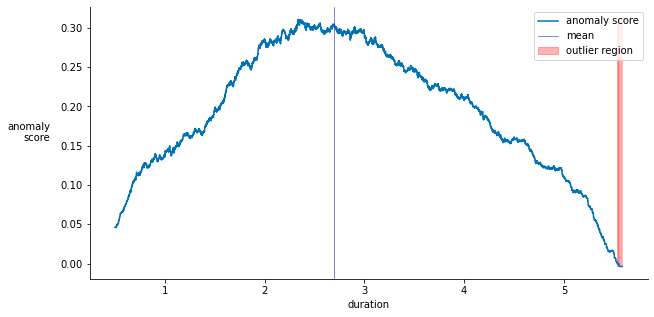

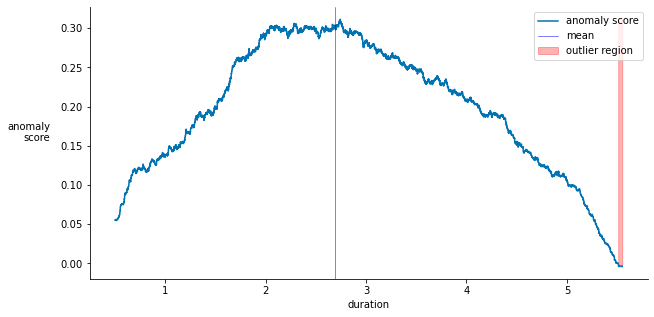

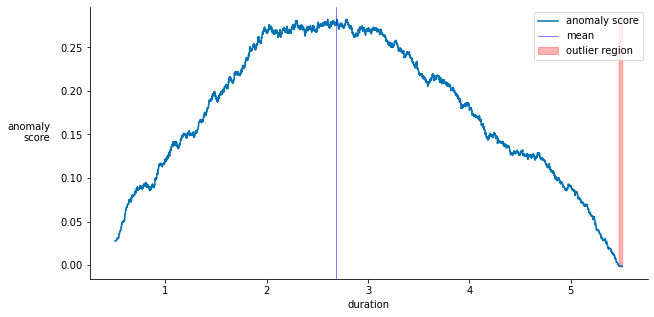

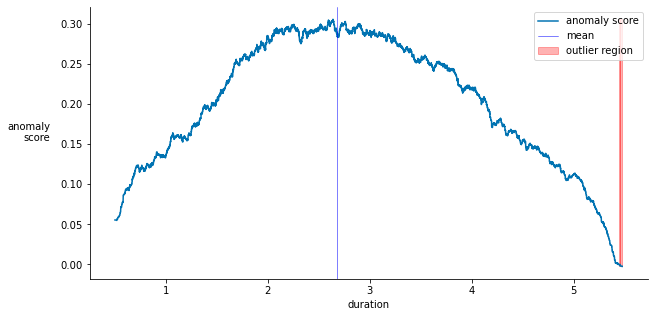

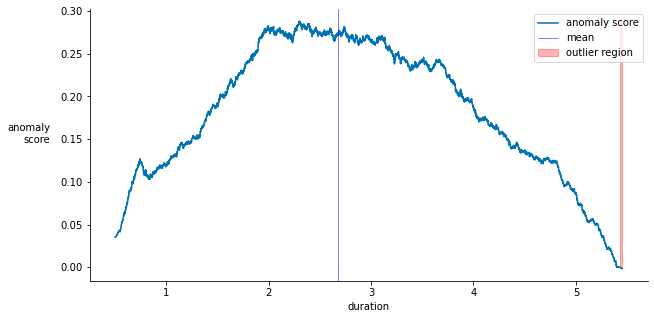

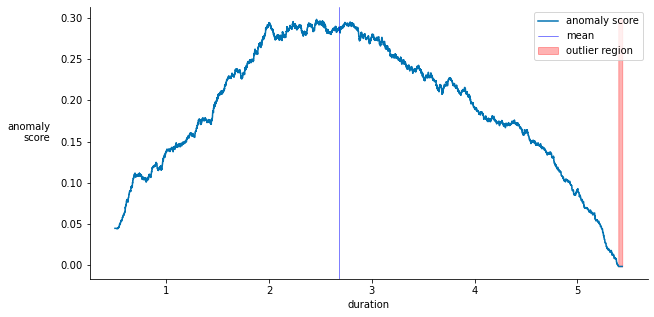

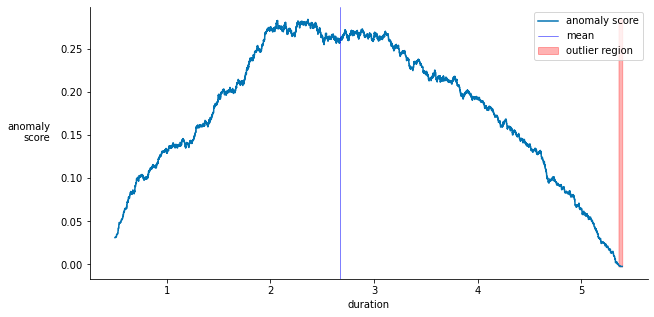

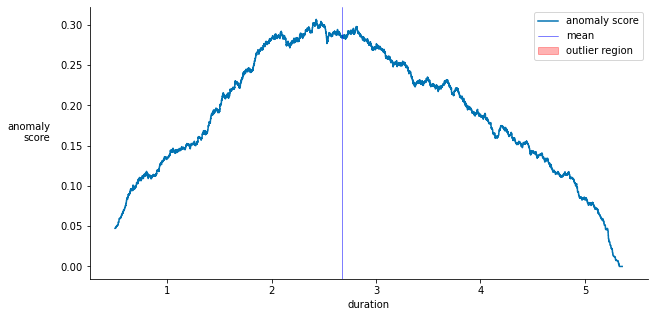

no outliers


In [40]:
new_mid = medium.copy()
contam = 0.0015
inliers, outliers = plot_IF_duration(new_mid, contamination=contam, suppress=False)
# while outliers are on one side of the mean
while not (
    outliers.duration.min() <= new_mid.duration.mean() <= outliers.duration.max()
):
    new_mid = inliers
    inliers, outliers = plot_IF_duration(new_mid, contamination=contam, suppress=False)
    if len(outliers) == 0:
        print("no outliers")
        break

Next, let's "reassemble" the long set from the samples above (just removed from the medium set) and the original long set (post-trim).

In [41]:
long_plus = trimmed_df.loc[trimmed_df.duration > new_mid.duration.max()]
len(long_plus) - len(long), ("new long")
len(long_plus)
long_plus.duration.min()
long_plus.duration.max()

len(new_mid), ("records in medium")
new_mid.duration.min()
new_mid.duration.max()

len(short), ("records in short")
short.duration.min()
short.duration.max()

(4280, 'new long')

5173

5.358

11.1539375

(81099, 'records in medium')

0.501

5.357

(480, 'records in short')

0.213

0.5

Let's also glance at the final isolation forest anomaly score plots (using the updated contamination rate).

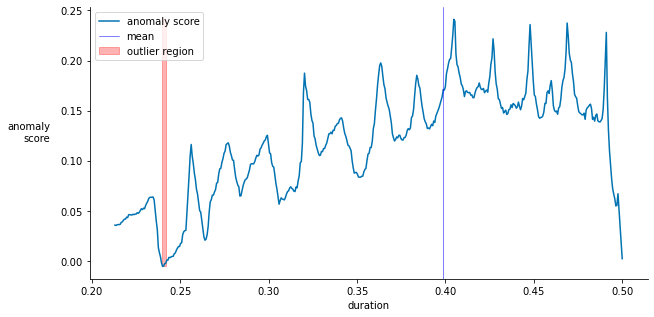

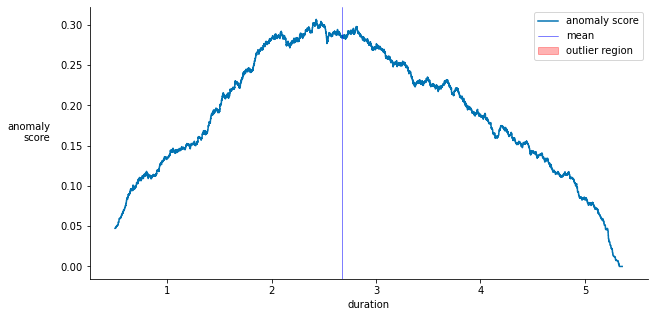

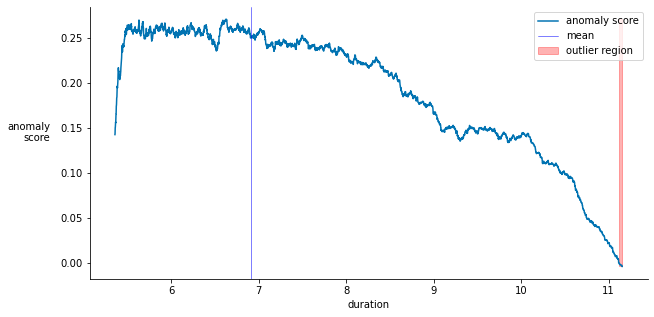

In [42]:
contam = 0.0015
plot_IF_duration(short, contamination=contam, return_xxliers=False)
plot_IF_duration(new_mid, contamination=contam, return_xxliers=False)
plot_IF_duration(long_plus, contamination=contam, return_xxliers=False)

An isolation forest no longer detects anomalies in the medium set at the current contamination rate and as before, anomalous regions are detected at the short and long ends of the short and long sets, respectively. In my opinion, the face validity of the new thresholds - at approximately 0.5, 5.5, and 11 seconds - is improved.

In [43]:
trimmed_df["length"] = np.select(
    (
        trimmed_df.duration <= (threshold_lo := short.duration.max()),
        (threshold_lo < trimmed_df.duration)
        & (trimmed_df.duration < (threshold_hi := long_plus.duration.min())),
        trimmed_df.duration >= threshold_hi,
    ),
    ("short", "medium", "long"),
)
trimmed_df.length.value_counts()

medium    81099
long       5173
short       480
Name: length, dtype: int64

## Compare

To check our work, let's see how the other characteristics compare between the three new sub-datasets.

In [44]:
def examine_segment(df: pd.DataFrame) -> None:
    sns.heatmap(
        pd.crosstab(df.speaker_gender, df.valence),
        cmap="coolwarm",
        vmin=0,
        vmax=df[["speaker_gender", "valence"]].value_counts().values.max(),
    )
    plt.suptitle("gender x valence")
    plt.ylabel("gender", labelpad=10, ha="right").set_rotation(0)
    plt.show()
    sns.heatmap(
        pd.crosstab(no_u := df.loc[df.speaker_gender != "u"].speaker_gender, df.neg),
        cmap="coolwarm",
        vmin=0,
        vmax=df[["speaker_gender", "valence"]].value_counts().values.max(),
    )
    plt.suptitle("gender (no 'u') x neg/non-neg")
    plt.ylabel("gender", labelpad=10, ha="right").set_rotation(0)
    plt.show()

short


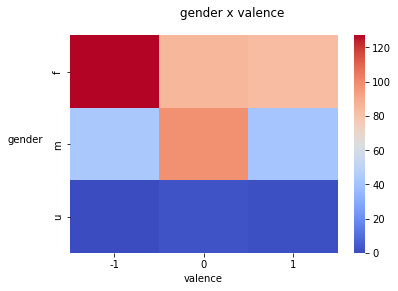

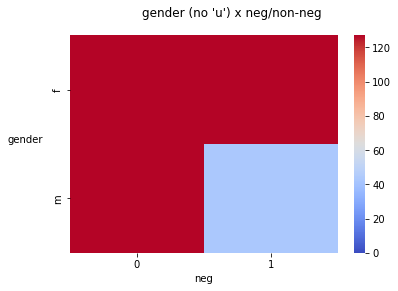

medium


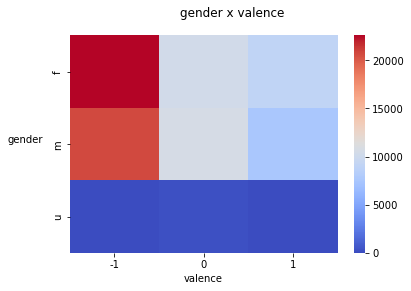

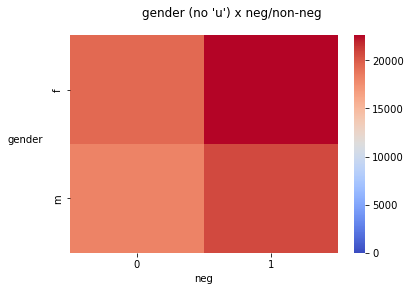

long


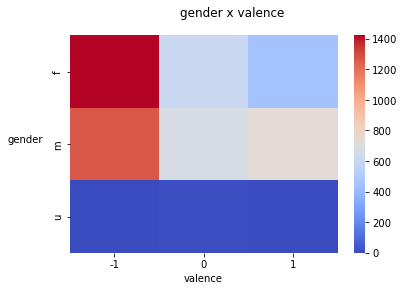

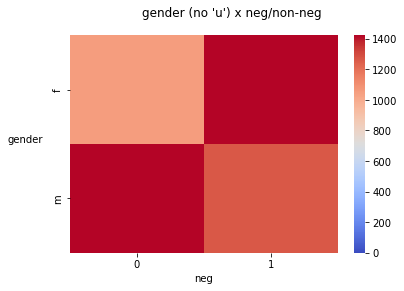

In [45]:
for _, df in zip(("short", "medium", "long"), (short, new_mid, long_plus)):
    print(_)
    examine_segment(df)

Apart from the short set (few negative clips from male speakers), these look pretty balanced by gender (excluding unknown) and negative/non-negative valence.

Text(0.5, 0.98, 'short')

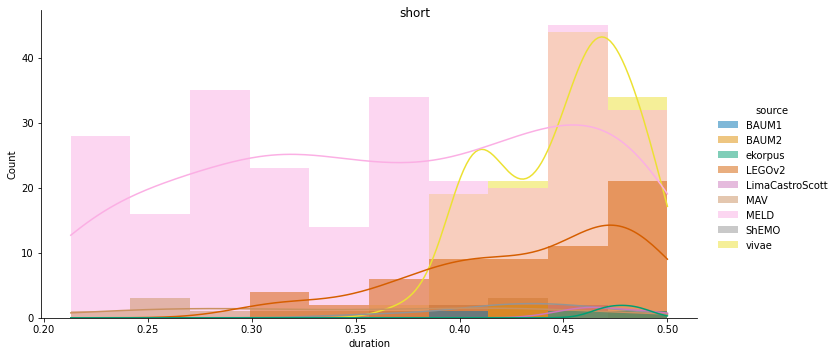

Text(0.5, 0.98, 'medium')

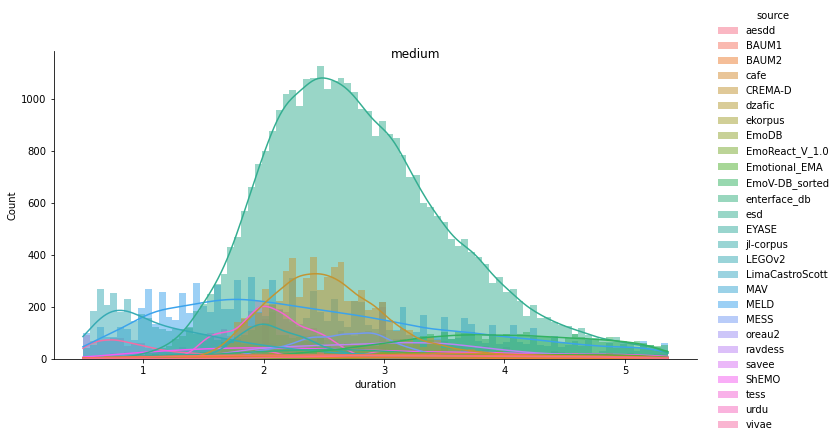

Text(0.5, 0.98, 'long')

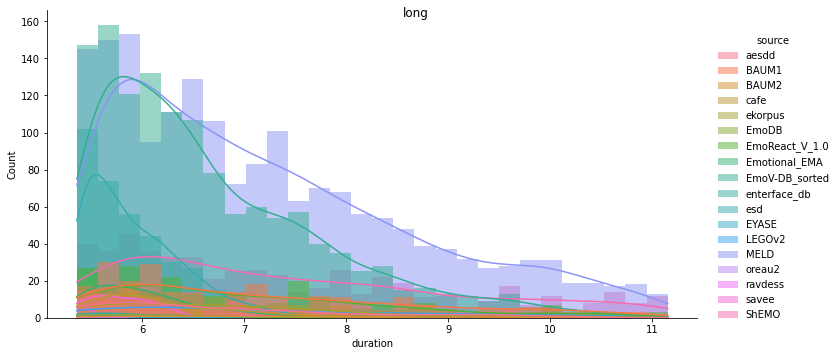

In [46]:
sns.displot(
    data=trimmed_df.loc[trimmed_df.length == "short"],
    x="duration",
    kde=True,
    linewidth=0,
    hue="source",
    aspect=2,
)
plt.suptitle("short")
plt.show()

sns.displot(
    data=trimmed_df.loc[trimmed_df.length == "medium"],
    x="duration",
    kde=True,
    linewidth=0,
    hue="source",
    aspect=2,
)
plt.suptitle("medium")
plt.show()

sns.displot(
    data=trimmed_df.loc[trimmed_df.length == "long"],
    x="duration",
    kde=True,
    linewidth=0,
    hue="source",
    aspect=2,
)
plt.suptitle("long")
plt.show()

In [47]:
def plot_valence(df):
    sns.displot(x=df.duration, kde=True, linewidth=0, hue=df.valence, aspect=2)
    plt.suptitle("Distribution of duration by valence")
    plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
    plt.show()
    df.valence.value_counts().plot(kind="pie")
    plt.show()

'short'

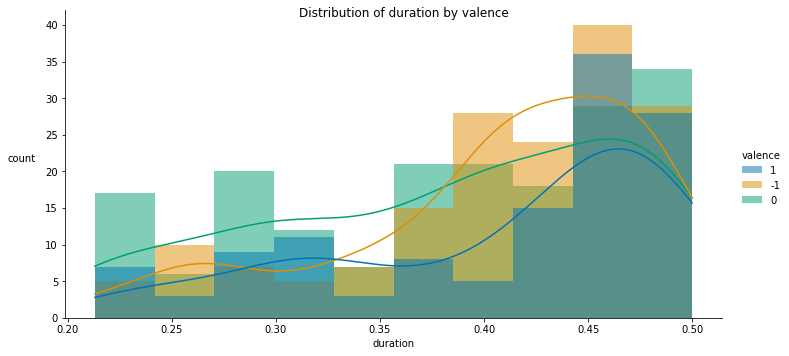

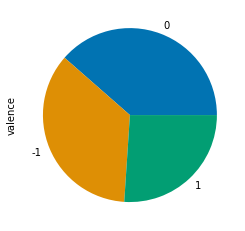

'medium'

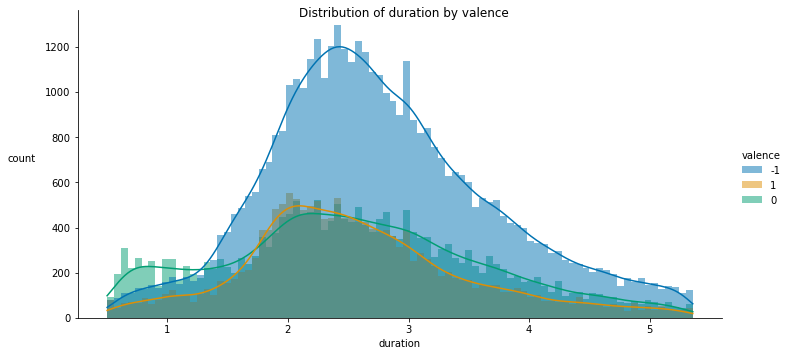

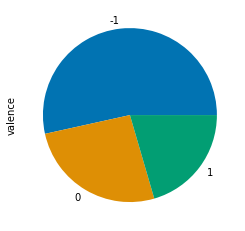

'long'

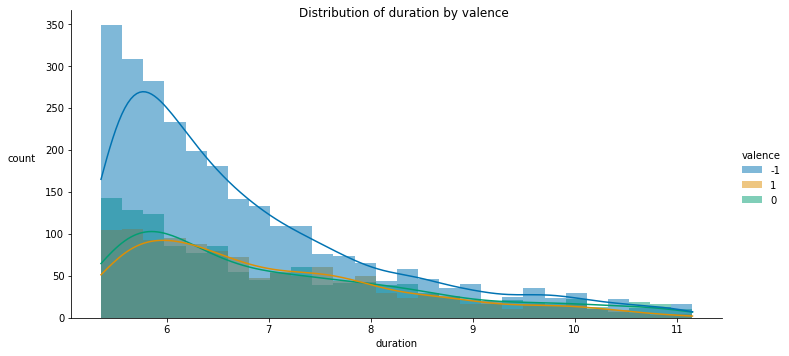

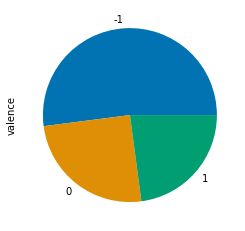

In [48]:
"short"
plot_valence(short)
"medium"
plot_valence(new_mid)
"long"
plot_valence(long_plus)

In [49]:
def plot_speaker_gender(df):
    sns.displot(x=df.duration, kde=True, linewidth=0, hue=df.speaker_gender, aspect=2)
    plt.suptitle("Distribution of duration by speaker_gender")
    plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
    plt.show()
    df.speaker_gender.value_counts().plot(kind="bar")
    despine_topright()
    plt.show()

'short'

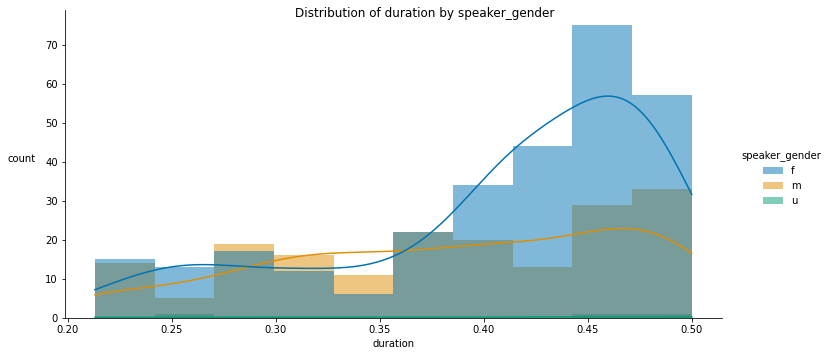

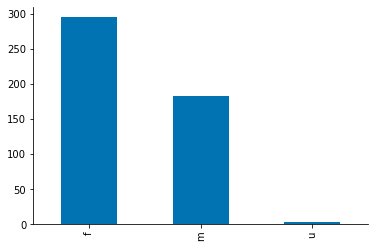

'medium'

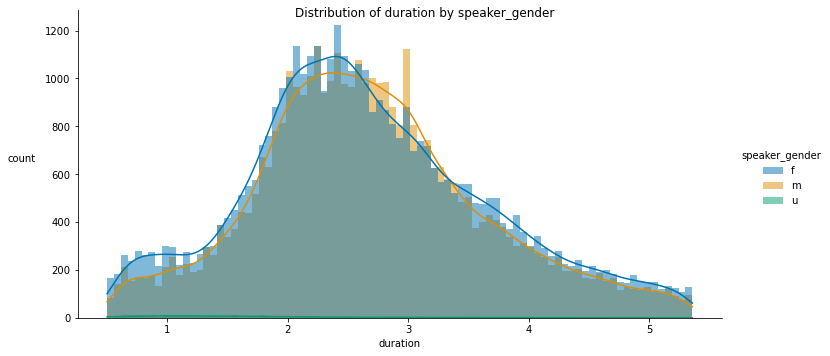

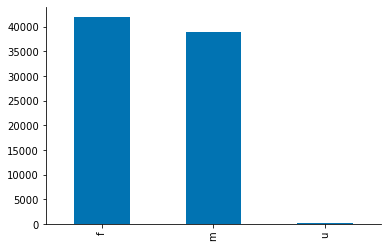

'long'

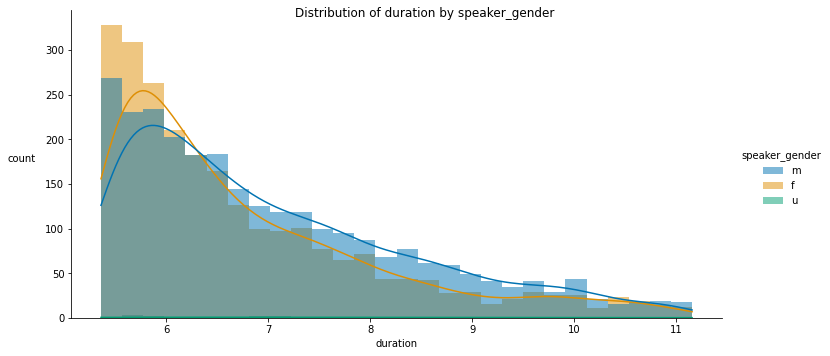

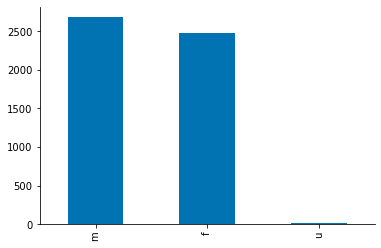

In [50]:
"short"
plot_speaker_gender(short)
"medium"
plot_speaker_gender(new_mid)
"long"
plot_speaker_gender(long_plus)

In [51]:
def plot_lang1(df):
    sns.displot(x=df.duration, kde=True, linewidth=0, hue=df.lang1, aspect=2)
    plt.suptitle("Distribution of duration by lang1")
    plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
    plt.show()
    df.lang1.value_counts().plot(kind="bar")
    despine_topright()
    plt.show()

'short'

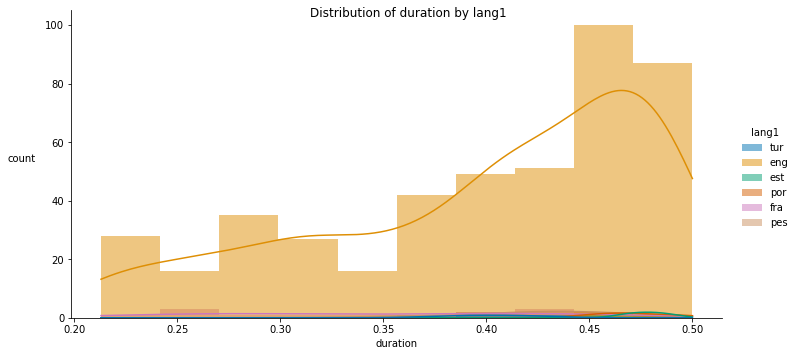

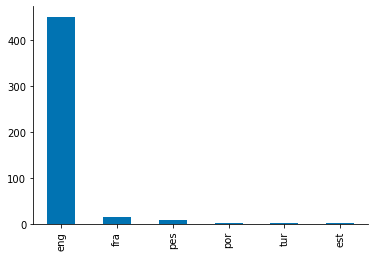

'medium'

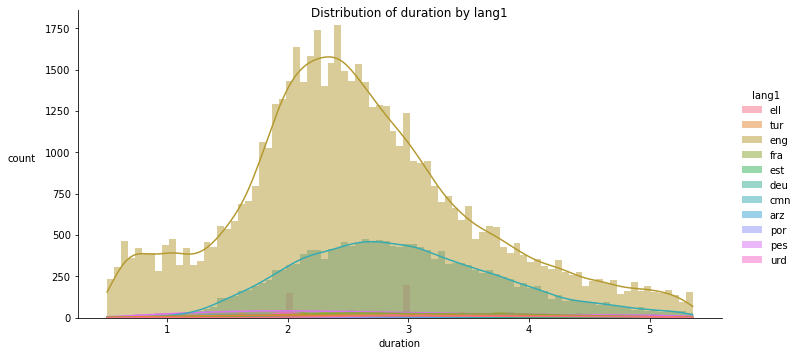

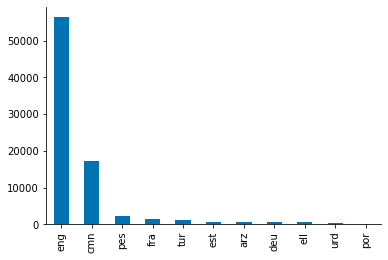

'long'

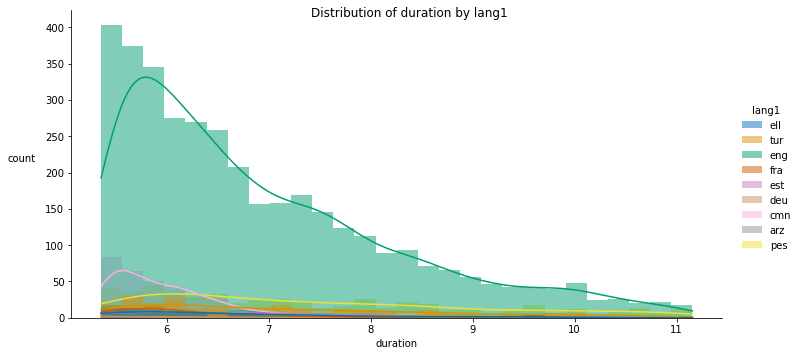

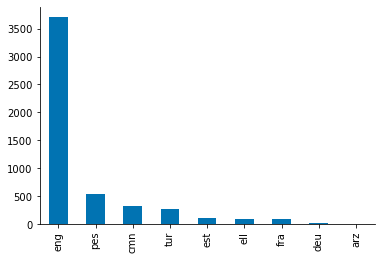

In [52]:
"short"
plot_lang1(short)
"medium"
plot_lang1(new_mid)
"long"
plot_lang1(long_plus)

In [53]:
def plot_lang1noeng(df):
    df = df.loc[df.lang1 != "eng"]
    sns.displot(x=df.duration, kde=True, linewidth=0, hue=df.lang1, aspect=2)
    plt.suptitle("Distribution of duration by lang1")
    plt.ylabel("count", labelpad=10, ha="right").set_rotation(0)
    plt.show()
    df.lang1.value_counts().plot(kind="bar")
    despine_topright()
    plt.show()

'short'

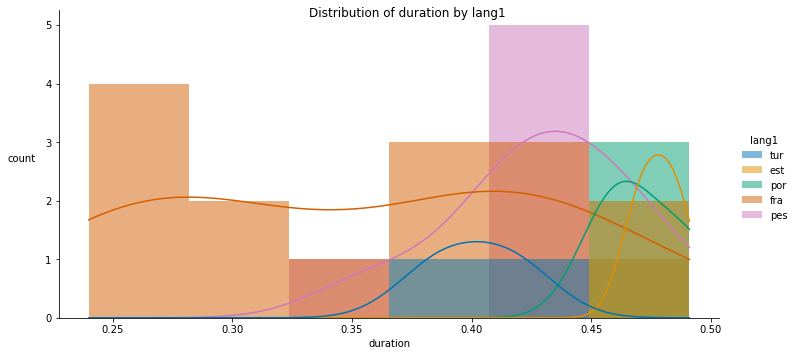

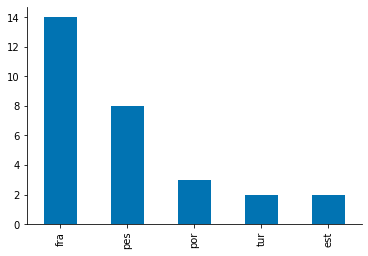

'medium'

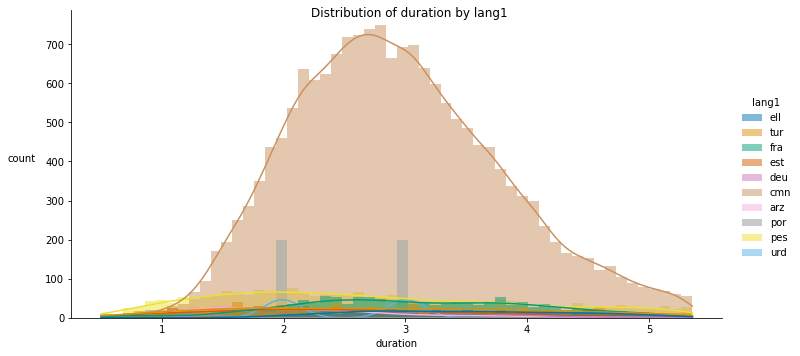

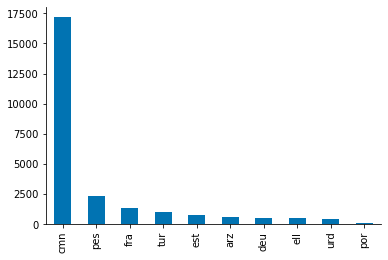

'long'

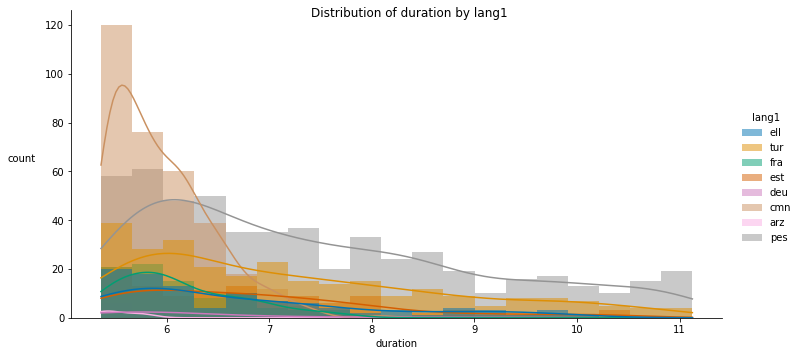

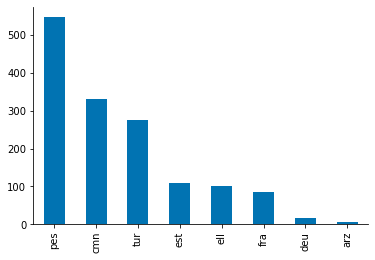

In [54]:
"short"
plot_lang1noeng(short)
"medium"
plot_lang1noeng(new_mid)
"long"
plot_lang1noeng(long_plus)

## Export dataframes

In [55]:
short["length"] = "short"
new_mid["length"] = "medium"
long_plus["length"] = "long"

official_trimmed_df = trimmed_df.drop("outlier", axis="columns")
official_short = short.drop("outlier", axis="columns")
official_new_mid = new_mid.drop("outlier", axis="columns")
official_long_plus = long_plus.drop("outlier", axis="columns")

all(official_trimmed_df.loc[official_trimmed_df.length == "short"] == official_short)
all(official_trimmed_df.loc[official_trimmed_df.length == "medium"] == official_new_mid)
all(official_trimmed_df.loc[official_trimmed_df.length == "long"] == official_long_plus)

True

True

True

In [56]:
to_discard["length"] = "discard"
official_discard = to_discard.drop("outlier", axis="columns")

In [57]:
official_trimmed_df.to_pickle(f"{DATA_OUT_FOLDER}/trimmed_dataframe.pkl")
official_short.to_pickle(f"{DATA_OUT_FOLDER}/short.pkl")
official_new_mid.to_pickle(f"{DATA_OUT_FOLDER}/medium.pkl")
official_long_plus.to_pickle(f"{DATA_OUT_FOLDER}/long.pkl")
official_discard.to_pickle(f"{DATA_OUT_FOLDER}/discard.pkl")

## Conclusion

In this notebook, we explored sample durations. The data were divided into groups of short, medium, and long duration to mitigate the degree of signal distortion as sample durations are made uniform downstream.

Using isolation forest, we were able to 1) discard the longest samples, 2) divide the remaining into short, medium, and long portions, and then 3) tweak the balance between the medium and long sets. The approach worked for this dataset because a) we chose low contamination rates and b) we have domain knowledge that helps us infer where the anomalous regions should be.

I had thought about trying a similarly iterative approach with normality tests, but the kurtosis is very high. This alternative approach may require rescaling such as log transformation. Isolation forest would be robust against such scaling effects as it is a partition-based algorithm.

[^top](#Contents)